# **Skin Cancer Detection from Dermoscopic Images Using Deep Convolutional Neural Networks (CNN)**

##**Project Objective**

The goal of this capstone is to predict whether a dermoscopic image (skin image) is malignant (skin cancer) using low-resolution images combined with a small set of patient metadata. The emphasis is on building a realistic, reproducible pipeline under practical constraints rather than maximizing benchmark performance.

##**Dataset and Practical Constraints**

This project is based on The International Skin Imaging Collaboration (ISIC) 2020 'Skin Lesion Analysis: Towards Melanoma Detection' dataset (≈33,000 images, ~50GB in full resolution). https://challenge2020.isic-archive.com/

Working with the original high-resolution dermoscopic images was not feasible for this capstone due to storage limits and compute constraints. To address this, I used a pre-resized 224×224 JPG version of the ISIC 2020 dataset available on Kaggle:

https://www.kaggle.com/datasets/nischaydnk/isic-2020-jpg-224x224-resized

**This decision introduced an important trade-off**: This is an extemely difficult dataset as it has extreme imbalance. The model performance is expected to be lower than approaches trained on full-resolution dermoscopy images. This trade-off is intentional due to storage and compute limits as mentioned before.

##**Key Challenges and Design Decisions**

*   **Google Colab instability resolution** Training directly from Google Drive createed a performance and reliability problem because reading thousands of small image files incured high I/O latency and intermittently stalled and disconnected during long runs.  The solution was to copy and unzip the image dataset into the local runtime once, then load metadata, construct file paths, and verify image integrity so training used fast, stable local disk access.

*   **Severe Class Imbalance:** Malignant cases are rare relative to benign lesions. Accuracy calculation is therefore misleading. The model can achieve high accuracy by simply predicting the majority class (Benign or not cancer) most of the time, while completely failing to identify the minority class (malignant or cancer). To properly evaluate performance under imbalance, **PR-AUC (Precision-Recall Area Under Curve)** was used as the primary evaluation metric, with **ROC-AUC (Receiver Operating Characteristic Area Under Curve)** reported as a secondary reference

*   **Leakage Prevention:** There are multiple images per patient in the dataset and the images are highly correlated. To avoid leakage, I have split the dataset strictly at the **patient level** using patient_id, to ensure that no patient appears in more than one of train, validation, or test sets.

*  **Image level prevalance** Malignant images are rare in the dataset, so care had to be taken to ensure that the right proportion of maligant images were in train, val and test datasets.

##**Exploratory Data Analysis (EDA)**

A very limited set of metadata were provided with the images. The following was done:

*   Missing-value and metadata sanity checks
*   **Class imbalance analysis:** The splits had to be carefully done to ensure both benign and malignant images were present in the train, val and test dataset in similar proportions.
*   **Patient-level distribution checks:** Ensured that the train, val , test splits did not contain the same patient's dermascoping images.

##**Feature Engineeering**

*  **Age normalization and binning**
Age was converted to a numeric value, bucketed into ordered ranges, and augmented with an explicit missing flag.

*  **Sex and site missingness handling**
Missing sex and anatomical site values were encoded using binary indicators and  "Unknown" category.

*  **Anatomical site consolidation**
Rare anatomical sites were grouped into an "Other" category using training-only split to reduce sparsity and overfitting.

*  **Categorical interaction features**
Sex–site and age–site interaction features were created to capture conditional risk patterns beyond marginal effects.

*  **Leakage-safe default handling**
Unseen patients were assigned neutral defaults, with positive-rate imputation based on the training-set mean only.

*  **Split-safe application**
All feature statistics were learned on the training set and applied identically to train, validation, and test splits.

##**Models Implemented**

###**1. Baseline Model with metadata: LogisticRegression**

Used patient-level metadata with guaranteed malignant/ benign data within train, val test, data to establish a baseline. this also demonstrates the predictive value of metadata alone.

###**2.LogisticRegression with Hyperparameter tuning - Cross Validation and GridSearch**
Class-weighted Logistic Regression (which up-weights the rare positive class to counter the 1–2% prevalence) is fitted and tuned with **5-fold GroupKFold** by patient_id to avoid same-patient leakage across folds. Then **GridSearch** explores **L1 vs L2 regularization** (sparsity/selective feature use vs smooth shrinkage) and **different regularization strengths** (C) to select the best setting by **cross-validated** PR-AUC.

###**3. Baseline Model with metadata: Gradient Boosted Decision Trees (GBDT) - HistGradientBoostingClassifier**

Trained a metadata-only **HistGradientBoostingClassifier** with one-hot encoded categorical features and median-imputed numeric features. I used HistGradientBoostingClassifier because **Gradient Boosted Decision Trees** can capture non linear relationships and feature interactions that logistic regression often misses.

###**4. Image-Only Convolutional Neural Network (CNN) Model EfficientNet-B0**

*(EfficientNet-b0 is a convolutional neural network that is trained on more than a million images from the ImageNet database.)*
I used reduced size 224×224 pixel dermoscopic images in all CNN models.

I chose it because it is widely used for image classification, often outperforming much larger models like ResNet with significantly fewer parameters. Pretrained on ImageNet dataset images features that transfer well, so head-only training is a reliable.

Training strategy: Freeze backbone and train only classifier head.

Used (torchvision) for light augmentation (flip and small rotation).

Imbalance handling: Used pos_weight = neg/pos inside **BCEWithLogitsLoss** to upweight positives (malignant).

Used **AdamW** optimizer during training to update the model’s trainable weights and to reduce the **loss**.


###**5. Convolutional Neural Network (CNN) Model - EfficientNet-B0 with image aumentaion using Albumentations**

The training pipeline uses **Albumentations** to apply a richer and more diverse set of image augmentations. Each training image is first **resized** to a fixed input size. It is then **randomly flipped horizontally and vertically** to improve invariance to orientation. Next, an affine transformation is applied, which includes **small random translations, scaling, and rotations** of up to ±20 degrees to **increase geometric robustness**.

After the geometric transformations, **color and illumination variations** are introduced through random **brightness and contrast adjustments, hue and saturation shifts, and gamma corrections**. To further improve robustness to image quality variations common in real-world data, the pipeline occasionally applies **mild blurring or Gaussian noise**. Finally, the image is normalized using ImageNet mean and standard deviation and converted into a PyTorch tensor using ToTensorV2

Training strategy is the same as before, freeze backbone and train only classifier head.


###**6. Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation**

* Images are resized, augmented, normalized with ImageNet statistics, and converted to tensors, while class imbalance is handled using a weighted binary cross-entropy loss.
* **In Stage 1**, the pretrained backbone is frozen and only the classifier head is trained, with validation PR-AUC used for early stopping and checkpoint selection.
* **In Stage 2**, the best Stage 1 model is reloaded and only the final EfficientNet block plus the classifier head are fine-tuned using a lower learning rate for the backbone.
* The final model is evaluated on the test set using PR-AUC and ROC-AUC.

###**7. Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation and imbalance handling with WeightedRandomSampler**

Two-stage fine-tune: (S1) head-only, (S2) last block + head (lower LR)
Imbalance handling : WeightedRandomSampler
Loss : BCEWithLogitsLoss
Stronger Albumentations aug: Affine and color and blur/noise and coarse dropout

Best reseults.

###**8.  STACKING - IMAGE MODEL: Convolutional Neural Network (CNN) Model - EfficientNet-B0 using two stage fine tuning and strong albumentation and weightedRandomSampler with METADATA MODEL: LogisticRegression with Cross Validation and GridSearch**

Here CNN image-based probabilities and metadata-based probabilities are combined by training a logistic regression model on the validation set.

###**9 Evaluation on Test set**
Finally Evaluation was done using best performing model on unseen TEST set

##**Going above and Beyond**

I have used the Model weights and Gradio 6.3.0 to create an UI based application in HuggingFace Spaces
**Skin Lesion Risk Demo**
This App

* accepts a skin lesion photo upload
* runs EfficientNet-B0 inference from a saved .pt checkpoint
* shows probability + decision at a chosen threshold
* shows Grad-CAM overlay and heatmap
* provides Q&A using RAG + OpenAI API


##Evaluate best performing model on unseen TEST set
Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation and imbalance handling with WeightedRandomSampler had the best rank using PR-AUC.

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Standard package imports

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os, gc, logging, random, shutil, zipfile
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Set, Mapping, Sequence, Callable, Optional
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import GroupKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import torch
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
from torch.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2




## Activate logging

In [3]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s", force=True)
logger = logging.getLogger("capstone")

## Path definitions

In [4]:
project_drive_path_str = "/content/drive/MyDrive/final_capstone_project"
project_drive_root = Path(project_drive_path_str)

raw_data_directory = project_drive_root / "raw"
artifact_output_directory = project_drive_root / "artifacts"
metadata_directory = project_drive_root / "meta"

local_dataset_root = Path("/content/datasets/isic2020_256")
local_data_directory = Path("/content/datasets/isic2020_256/data")

# Ensure directories exist
raw_data_directory.mkdir(parents=True, exist_ok=True)
artifact_output_directory.mkdir(parents=True, exist_ok=True)
metadata_directory.mkdir(parents=True, exist_ok=True)
local_dataset_root.mkdir(parents=True, exist_ok=True)

logger.info(
    "raw_dir: %s\n artifacts_dir: %s\n meta_dir: %s\n data_dir: %s ",
    raw_data_directory, artifact_output_directory, metadata_directory, local_data_directory
)



INFO: raw_dir: /content/drive/MyDrive/final_capstone_project/raw
 artifacts_dir: /content/drive/MyDrive/final_capstone_project/artifacts
 meta_dir: /content/drive/MyDrive/final_capstone_project/meta
 data_dir: /content/datasets/isic2020_256/data 


## Utility functions

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)


# Check if a given pandas DataFrame contains all the specified columns.
def require_columns(df: pd.DataFrame, required: Sequence[str]) -> None:
    missing_cols = [c for c in required if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")


#  outputs example "loss=0.21 | epoch=3 | split=val"
def info_dict(fields: Mapping[str, object]) -> str:
    parts = (f"{key}={value}" for key, value in fields.items())
    return " | ".join(parts)

#plots
def plot_model_val_auc(y_true, y_prob, *, name="VAL", print_metrics=True, color=None,):

    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    prevalence = float(y_true.mean()) if y_true.size else float("nan")
    pr_auc = float(average_precision_score(y_true, y_prob))

    try:
        roc_auc = float(roc_auc_score(y_true, y_prob))
    except ValueError:
        roc_auc = float("nan")

    if print_metrics:
        print(f"[{name}] PR-AUC={pr_auc:.5f} | ROC-AUC={roc_auc:.5f} | prevalence={prevalence:.5f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # PR curve
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    axes[0].plot(rec, prec, color=color)
    axes[0].axhline(prevalence, linestyle="--", alpha=0.6)
    axes[0].set_title(f"{name} Precision–Recall\nPR-AUC={pr_auc:.4f} | baseline={prevalence:.4f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[1].plot(fpr, tpr, color=color)
    axes[1].plot([0, 1], [0, 1], linestyle="--", alpha=0.6)
    axes[1].set_title(f"{name} ROC\nAUC={roc_auc:.4f}" if np.isfinite(roc_auc) else f"{name} ROC\nAUC=—")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")

    plt.tight_layout()
    plt.show()

    return {"name": str(name), "prevalence": prevalence, "pr_auc": pr_auc, "roc_auc": roc_auc}


#ks: fractions of the dataset to 'review' from highest score down (e.g., 0.05 = top 5%).
#Returns recall@k, precision@k, lift@k for each k.
#Will use k values only if PR-AUC results in ties.
def rank_metrics_at_k(y_true, y_prob, *, ks=(0.01, 0.05, 0.10)):

    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    n = int(len(y_true))
    prevalence = float(y_true.mean()) if n else 0.0

    order = np.argsort(-y_prob)  # descending by score
    y_sorted = y_true[order]

    out = {"prevalence": prevalence}

    for k in ks:
        pct = int(round(100 * float(k)))
        top_n = max(1, int(round(k * n)))

        y_top = y_sorted[:top_n]
        tp_top = int(y_top.sum())

        total_pos = int(y_true.sum())
        recall = float(tp_top / total_pos) if total_pos > 0 else 0.0
        precision = float(tp_top / top_n) if top_n > 0 else 0.0
        lift = float(precision / prevalence) if prevalence > 0 else 0.0

        out[f"recall@{pct}%"] = recall
        out[f"precision@{pct}%"] = precision
        out[f"lift@{pct}%"] = lift

    return out

def print_rank_metrics_at_k(metrics: dict, *, title="VAL"):
    prevalence = metrics.get("prevalence", 0.0)
    pcts = sorted(
        int(k.split("@")[1].replace("%", ""))
        for k in metrics.keys()
        if k.startswith("recall@")
    )

    print(f"\n{title} ranking metrics (prevalence={prevalence:.4f})")
    print(f"{'Top K':>6} | {'Recall':>7} | {'Precision':>9} | {'Lift':>6}")
    print("-" * 38)

    for pct in pcts:
        r = metrics.get(f"recall@{pct}%", 0.0)
        p = metrics.get(f"precision@{pct}%", 0.0)
        l = metrics.get(f"lift@{pct}%", 0.0)
        print(f"{pct:>5}% | {r:7.4f} | {p:9.4f} | {l:6.2f}")



def plot_model_diagnostics(y_true,y_prob,*,name="TEST",color=None,bins=50,threshold=0.5,target_recall=None,   fallback="closest",   print_metrics=True):

    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)


    if target_recall is not None:
        precision_arr, recall_arr, thresholds_arr = precision_recall_curve(y_true, y_prob)

        # align thresholds with precision[1:], recall[1:]
        precision_t, recall_t = precision_arr[1:], recall_arr[1:]

        valid = np.where(recall_t >= float(target_recall))[0]

        if len(valid) == 0:
            if fallback == "fixed":
                chosen_thresh = float(threshold)
                chosen_i = None
            else:
                #closest recall to target
                chosen_i = int(np.argmin(np.abs(recall_t - float(target_recall))))
                chosen_thresh = float(thresholds_arr[chosen_i])
        else:
            chosen_i = int(valid[np.argmax(precision_t[valid])])
            chosen_thresh = float(thresholds_arr[chosen_i])

        threshold = chosen_thresh

        if print_metrics:
            if chosen_i is None:
                print(f"[{name}] chosen threshold (fallback fixed) = {threshold:.5f}")
            else:
                print(
                    f"[{name}] chosen threshold = {threshold:.5f} "
                    f"(target_recall={float(target_recall):.2f} | "
                    f"Precision={float(precision_t[chosen_i]):.5f} Recall={float(recall_t[chosen_i]):.5f})"
                )

    prevalence = float(y_true.mean()) if y_true.size else float("nan")
    pr_auc = float(average_precision_score(y_true, y_prob))

    try:
        roc_auc = float(roc_auc_score(y_true, y_prob))
    except ValueError:
        roc_auc = float("nan")

    y_pred = (y_prob >= float(threshold)).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = (int(cm[0, 0]), int(cm[0, 1]), int(cm[1, 0]), int(cm[1, 1]))

    pred_pos = int(tp + fp)
    precision = float(tp / pred_pos) if pred_pos > 0 else 0.0
    recall = float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0
    f1 = float((2 * precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0.0

    if print_metrics:
        print(
            f"[{name}] threshold={float(threshold):.5f} | "
            f"PR-AUC={pr_auc:.5f} | ROC-AUC={roc_auc:.5f} | prevalence={prevalence:.5f} | "
            f"precision={precision:.5f} recall={recall:.5f} F1={f1:.5f} | "
            f"CONFUSION MATRIX: TN={tn} FP={fp} FN={fn} TP={tp}"
        )

    fig, axes = plt.subplots(1, 5, figsize=(28, 4))

    # Precision–Recall
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    axes[0].plot(recall_curve, precision_curve, color=color)
    axes[0].axhline(prevalence, linestyle="--", alpha=0.6)
    axes[0].set_title(f"{name} Precision–Recall\nPR-AUC={pr_auc:.4f} | baseline={prevalence:.4f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")

    # Cumulative recall
    sorted_idx = np.argsort(-y_prob)
    y_sorted = y_true[sorted_idx]
    cumulative_tp = np.cumsum(y_sorted)
    total_tp = y_true.sum()
    frac_reviewed = np.arange(1, len(y_true) + 1) / len(y_true)
    cumulative_recall = (cumulative_tp / total_tp) if total_tp > 0 else np.zeros_like(cumulative_tp)
    axes[1].plot(frac_reviewed * 100, cumulative_recall * 100, color=color)
    axes[1].plot([0, 100], [0, 100], linestyle="--", alpha=0.6)
    axes[1].set_title(f"{name} Cumulative Recall")
    axes[1].set_xlabel("% of images reviewed")
    axes[1].set_ylabel("% of positives found")

    # Score distributions
    axes[2].hist(y_prob[y_true == 0], bins=bins, alpha=0.6, label="Negative")
    axes[2].hist(y_prob[y_true == 1], bins=bins, alpha=0.6, label="Positive")
    axes[2].set_title(f"{name} Score Distribution")
    axes[2].set_xlabel("Predicted probability")
    axes[2].set_ylabel("Count")
    axes[2].legend()

    # ROC curve
    fpr_curve, tpr_curve, _ = roc_curve(y_true, y_prob)
    axes[3].plot(fpr_curve, tpr_curve, color=color)
    axes[3].plot([0, 1], [0, 1], linestyle="--", alpha=0.6)
    axes[3].set_title(f"{name} ROC\nAUC={roc_auc:.4f}" if np.isfinite(roc_auc) else f"{name} ROC\nAUC=—")
    axes[3].set_xlabel("False Positive Rate")
    axes[3].set_ylabel("True Positive Rate")

    # Confusion matrix
    norm = LogNorm(vmin=1, vmax=max(cm.max(), 1))
    axes[4].imshow(cm, cmap="Blues", norm=norm)
    axes[4].set_title(f"{name} Confusion Matrix\n(threshold={threshold:.2f})")
    axes[4].set_xticks([0, 1])
    axes[4].set_yticks([0, 1])
    axes[4].set_xticklabels(["Pred 0", "Pred 1"])
    axes[4].set_yticklabels(["True 0", "True 1"])
    for i in range(2):
        for j in range(2):
            axes[4].text(
                j, i, cm[i, j],
                ha="center", va="center",
                fontsize=12, fontweight="bold", color="black"
            )

    plt.tight_layout()
    plt.show()

    return {
        "name": str(name),
        "prevalence": prevalence,
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "threshold": float(threshold),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "cm": cm,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    }


def plot_cumulative_gain(y_true, y_prob, *, name="VAL", color=None):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    n = len(y_true)
    total_pos = int(y_true.sum())
    prevalence = float(y_true.mean()) if n else 0.0

    order = np.argsort(-y_prob)
    y_sorted = y_true[order]

    cum_tp = np.cumsum(y_sorted)
    if total_pos > 0:
        cum_recall = cum_tp / total_pos
    else:
        cum_recall = np.zeros_like(cum_tp, dtype=float)

    frac_reviewed = (np.arange(1, n + 1) / n)

    plt.figure(figsize=(7, 5))
    plt.plot(frac_reviewed * 100, cum_recall * 100, color=color, label=f"{name}")
    plt.plot([0, 100], [0, 100], linestyle="--", alpha=0.6, label="Random")
    plt.title(f"{name} Cumulative Gain / Recall vs % Reviewed\n(prevalence={prevalence:.4f})")
    plt.xlabel("% of images reviewed (highest score first)")
    plt.ylabel("% of positives found (recall)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def collect_probs_from_loader(model, loader, *, device):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            y_list.append(y.detach().cpu().numpy())
            p_list.append(p)

    y_true = np.concatenate(y_list).astype(int)
    y_prob = np.concatenate(p_list).astype(float)
    return y_true, y_prob




## Instability issue resolution

Processing image files from 'My Drive' of google was creating instability and not completing. So I updated the code to move the image files to local google runtime disk that is allocated per session. I ofcourse keep the image zip file in 'My Drive' directory but for every run unzip it to local sessions disk and  process it. this makes the execution smoother and faster.




In [6]:
#Locate the zip file
zip_files = sorted(raw_data_directory.glob("*.zip"))
if not zip_files:
    raise FileNotFoundError(f"No .zip found in {raw_data_directory}")

dataset_zip = zip_files[0]
if len(zip_files) > 1:
    print(f"Multiple zips found; using: {dataset_zip.name}")


#unzip to local runtime
images_dir = local_dataset_root/"train-image"/"image"

if not images_dir.exists():
    runtime_zip = Path("/content/isic2020_256.zip")
    if not runtime_zip.exists():
        print("Copying zip to local runtime...")
        shutil.copyfile(dataset_zip, runtime_zip)

    print(f"Unzipping into: {local_dataset_root}")
    with zipfile.ZipFile(runtime_zip, "r") as zf:
        zf.extractall(local_dataset_root)

    if not images_dir.exists():
        raise RuntimeError(f"Expected image folder missing after unzip: {images_dir}")
else:
    print("Images already present; skipping unzip")


#load the metadata file
meta_csv = metadata_directory / "train-metadata-new.csv"
if not meta_csv.exists():
    raise FileNotFoundError(f"Metadata CSV not found: {meta_csv}")

df = pd.read_csv(meta_csv)


# Verify that image files vexist
df["filepath"] = df["image_name"].astype(str).map(lambda name: str(images_dir / f"{name}.jpg"))

missing_images = (~df["filepath"].map(os.path.exists)).sum()
if missing_images:
    raise FileNotFoundError(f"{missing_images} .jpg files missing under: {images_dir}")

print("Loaded:", df.shape)
print("Images:", images_dir)
display(df.head())


Copying zip to local runtime...
Unzipping into: /content/datasets/isic2020_256
Loaded: (33126, 9)
Images: /content/datasets/isic2020_256/train-image/image


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,filepath
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/content/datasets/isic2020_256/train-image/ima...


##Data quality check

,missing_percent
anatom_site_general_challenge,1.590895
age_approx,0.205277
sex,0.196220
image_name,0.000000
patient_id,0.000000
diagnosis,0.000000
benign_malignant,0.000000
target,0.000000
filepath,0.000000


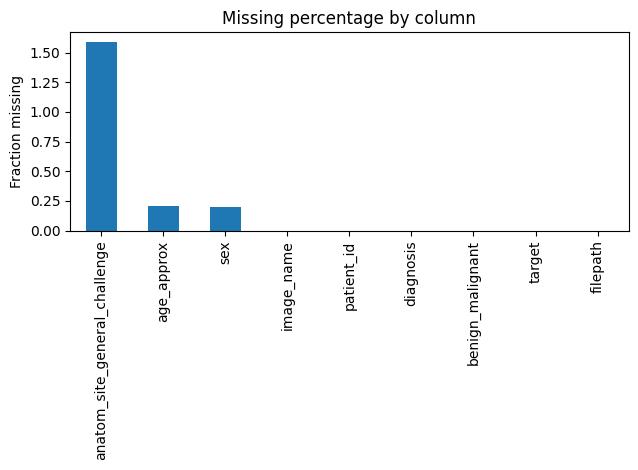

INFO: Duplicates: duplicate_rows=0 | duplicate_image_name=0


In [7]:
# Missing data by column
missing_percentage_by_col = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing_percentage_by_col.to_frame("missing_percent"))

plt.figure()
missing_percentage_by_col.plot(kind="bar")
plt.title("Missing percentage by column")
plt.ylabel("Fraction missing")
plt.tight_layout()
plt.show()

# Duplicates
dup_rows = int(df.duplicated().sum())
dup_image = int(df["image_name"].duplicated().sum())
logger.info("Duplicates: %s", info_dict({"duplicate_rows": dup_rows, "duplicate_image_name": dup_image}))




##Exploratory Data Analysis (EDA)

,count
target,
0,32542
1,584


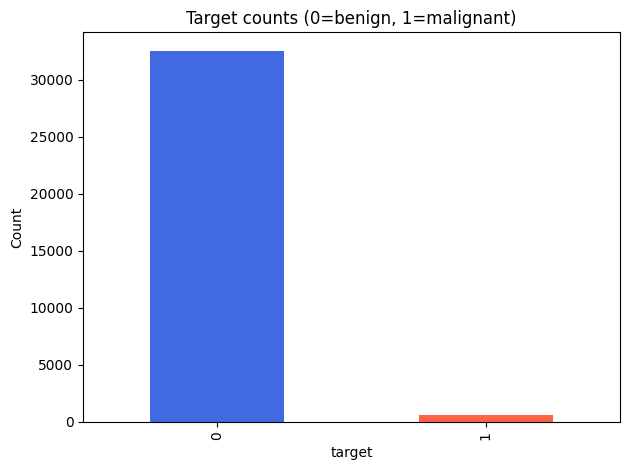

INFO: Dataset summary: target_prevalence=0.01762965646320111 | target_prevalence_percent=1.76 | unique_patients=2056


In [8]:
# Target distribution
target_counts = df["target"].value_counts(dropna=False).sort_index()
display(target_counts.to_frame("count"))

plt.figure()
target_counts.plot(kind="bar", color=["royalblue", "tomato"])
plt.title("Target counts (0=benign, 1=malignant)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Quick dataset summary
logger.info(
    "Dataset summary: %s",
    info_dict(
        {
            "target_prevalence": float(df["target"].mean()),
            "target_prevalence_percent": round(100 * float(df["target"].mean()), 2),
            "unique_patients": int(df["patient_id"].nunique()),
        }
    ),
)


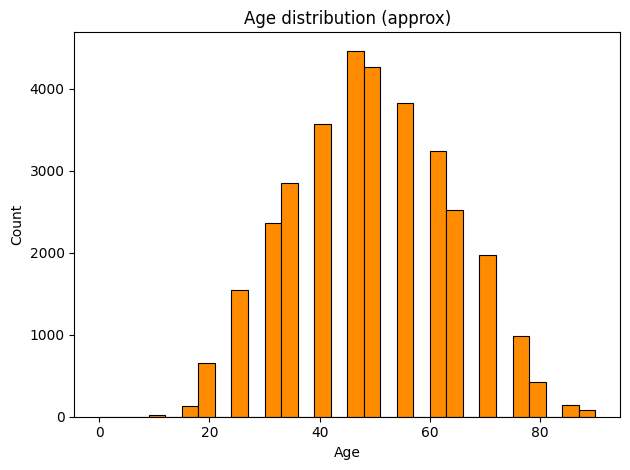

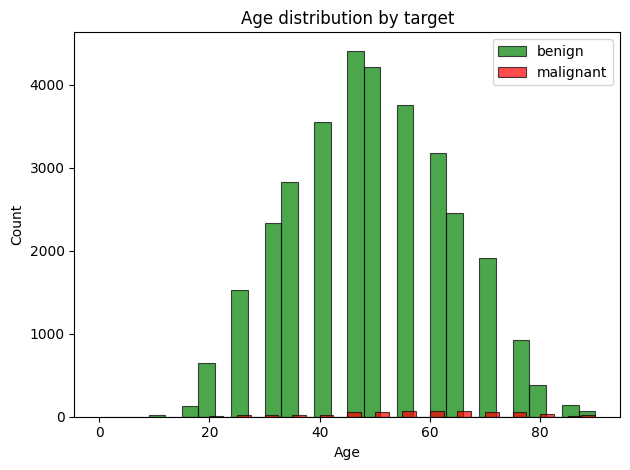

,count
anatom_site_general_challenge,
torso,16845
lower extremity,8417
upper extremity,4983
head/neck,1855
unknown,527
palms/soles,375
oral/genital,124


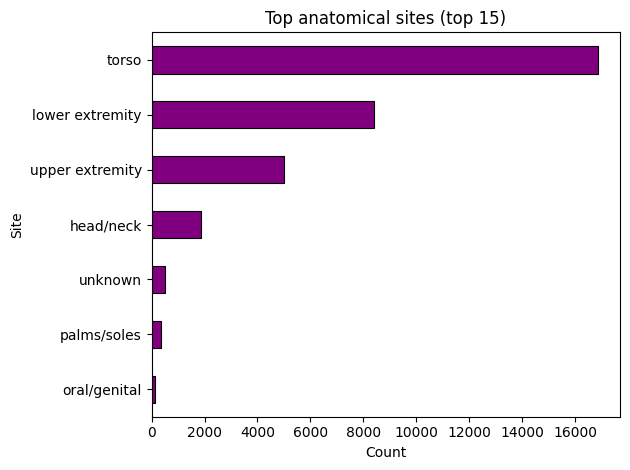

INFO: Patient-level positive rate: 0.2082
INFO: Patient-level positive percentage: 20.82%


In [9]:
# Make age numericand assign NaN to invalid age values
df["age_approx"] = pd.to_numeric(df["age_approx"], errors="coerce")

#plot age distribution in dataset
plt.figure()
df["age_approx"].dropna().plot(kind="hist", bins=30, color="darkorange", edgecolor="black", linewidth=0.8)
plt.title("Age distribution (approx)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# plot Age distribution by target
age_benign = df.loc[df["target"] == 0, "age_approx"].dropna()
age_malignant = df.loc[df["target"] == 1, "age_approx"].dropna()

plt.figure()
age_benign.plot(kind="hist", bins=30, alpha=0.7, label="benign", color="green", edgecolor="black", linewidth=0.8)
age_malignant.plot(kind="hist", bins=30, alpha=0.7, label="malignant", color="red", edgecolor="black", linewidth=0.8)
plt.title("Age distribution by target")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Top anatomical sites for skin cancer
site_col = df["anatom_site_general_challenge"].fillna("unknown")
site_counts_top15 = site_col.value_counts().head(15)

display(site_counts_top15.to_frame("count"))

plt.figure()
site_counts_top15.sort_values().plot(kind="barh", color="purple", edgecolor="black", linewidth=0.8)
plt.title("Top anatomical sites (top 15)")
plt.xlabel("Count")
plt.ylabel("Site")
plt.tight_layout()
plt.show()

#percentage of patients with cancer in the dataset
patient_has_malignant = df.groupby("patient_id")["target"].max()
logger.info("Patient-level positive rate: %.4f", float(patient_has_malignant.mean()))
logger.info("Patient-level positive percentage: %.2f%%",100 * float(patient_has_malignant.mean()),)









## Train / validation / test split (prevent data leakage by grouping images by patient_id)

A single patient can have multiple images. If the same patient's images appear in Train, Validation or Test dataset, it will be considered data leakage

**How:**  
1) Create a patient-level table with patient level target pt_target = max(target)  Example Patient P1 has 3 dermoscopic images, 2 of them are benign (0) and one is malignant (1). So max(target) will be 1 which will be the patient level target.
2) Split patients into train+val vs test keep the patient patient-level positive rate same for both groups (stratified)    
3) Split train and val patients into train vs val and keep the patient patient-level positive rate same for both groups (stratified)
4) Expand back to image rows and verify zero patient overlap

In [10]:
# Build a patient-level table for stratification (patient is positive if any of their images is malignant)
patient_table = df.groupby("patient_id")["target"].max().reset_index()
patient_table["patient_target"] = patient_table["target"]
patient_table = patient_table.drop(columns=["target"])

#Split into 2 sets, train+val and test and then split train and val keeping positive rate same
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
trainval_idx, test_idx = next(split1.split(patient_table, patient_table["patient_target"]))

trainval_patients = patient_table.iloc[trainval_idx].reset_index(drop=True)
test_patients_tbl = patient_table.iloc[test_idx].reset_index(drop=True)

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx, val_idx = next(split2.split(trainval_patients, trainval_patients["patient_target"]))

train_patient_ids = set(trainval_patients.iloc[train_idx]["patient_id"])
val_patient_ids   = set(trainval_patients.iloc[val_idx]["patient_id"])
test_patient_ids  = set(test_patients_tbl["patient_id"])

assert train_patient_ids.isdisjoint(val_patient_ids)
assert train_patient_ids.isdisjoint(test_patient_ids)
assert val_patient_ids.isdisjoint(test_patient_ids)


#train_df = all image rows whose patient_id is in train_patient_ids same for val test
train_df = df[df["patient_id"].isin(train_patient_ids)].copy()
val_df   = df[df["patient_id"].isin(val_patient_ids)].copy()
test_df  = df[df["patient_id"].isin(test_patient_ids)].copy()

#sort rows first by patient, then by image id for each patient
train_df = train_df.sort_values(["patient_id", "image_name"]).reset_index(drop=True)
val_df   = val_df.sort_values(["patient_id", "image_name"]).reset_index(drop=True)
test_df  = test_df.sort_values(["patient_id", "image_name"]).reset_index(drop=True)

all_split_patients = train_patient_ids | val_patient_ids | test_patient_ids
assert len(all_split_patients) == patient_table.shape[0], "Some patients were dropped."

def patient_positive_rate_percent(frame: pd.DataFrame) -> float:
    return 100 * float(frame.groupby("patient_id")["target"].max().mean())

logger.info( "Split sizes: %s", info_dict({ "train_rows": len(train_df), "val_rows": len(val_df), "test_rows": len(test_df)}))
logger.info( "Number of patients: %s", info_dict({ "train_patients": len(train_patient_ids),"val_patients": len(val_patient_ids),
             "test_patients": len(test_patient_ids)}))
logger.info( "Patient-level positive rate (%%): %s", info_dict({"train": round(patient_positive_rate_percent(train_df), 2),
             "val": round(patient_positive_rate_percent(val_df), 2),"test": round(patient_positive_rate_percent(test_df), 2)}))

# Save splits
metadata_directory.mkdir(parents=True, exist_ok=True)
train_df.to_csv(metadata_directory / "train_df.csv", index=False)
val_df.to_csv(metadata_directory / "val_df.csv", index=False)
test_df.to_csv(metadata_directory / "test_df.csv", index=False)

train_df_raw = train_df.copy()
val_df_raw   = val_df.copy()
test_df_raw  = test_df.copy()

logger.info("Saved split CSVs to: %s", metadata_directory)

INFO: Split sizes: train_rows=21585 | val_rows=5170 | test_rows=6371
INFO: Number of patients: train_patients=1315 | val_patients=329 | test_patients=412
INFO: Patient-level positive rate (%): train=20.84 | val=20.67 | test=20.87
INFO: Saved split CSVs to: /content/drive/MyDrive/final_capstone_project/meta


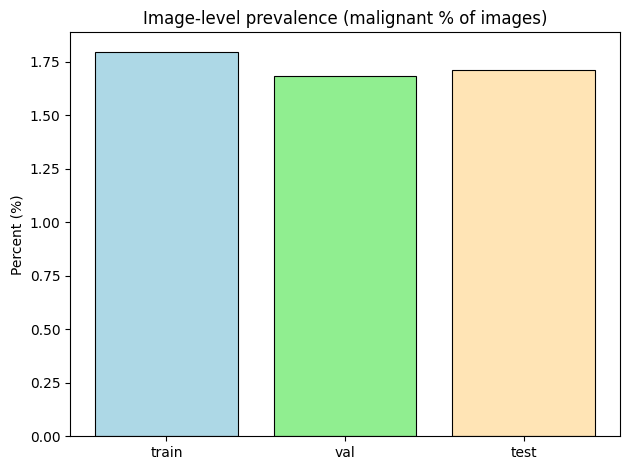

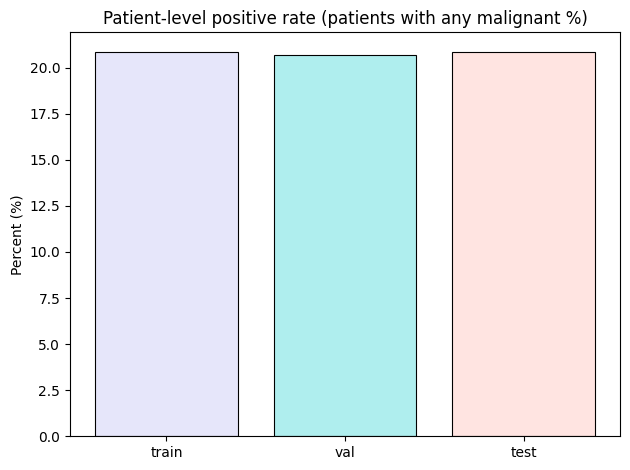

In [11]:
#verify Image-level prevalence (fraction of images with target=1)
img_prev = {
    "train": train_df["target"].mean(),
    "val":   val_df["target"].mean(),
    "test":  test_df["target"].mean(),
}

plt.figure()
plt.bar(list(img_prev.keys()), [100*v for v in img_prev.values()], color=["lightblue", "lightgreen", "moccasin"], edgecolor="black", linewidth=0.8)
plt.title("Image-level prevalence (malignant % of images)")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()

# Patient-level positive rate (fraction of patients with any target=1)
pt_prev = {
    "train": train_df.groupby("patient_id")["target"].max().mean(),
    "val":   val_df.groupby("patient_id")["target"].max().mean(),
    "test":  test_df.groupby("patient_id")["target"].max().mean(),
}

plt.figure()
plt.bar(list(pt_prev.keys()), [100*v for v in pt_prev.values()], color=["lavender", "paleturquoise", "mistyrose"], edgecolor="black", linewidth=0.8)
plt.title("Patient-level positive rate (patients with any malignant %)")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()


##Feature Engineering

In [12]:
#Age to categorical
age_bins = np.array([-1, 20, 30, 40, 50, 60, 70, 80, 200], dtype=float)
age_labels = ["0-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81+"]

#Not using rare sites to avoid overfitting
site_series = train_df_raw["anatom_site_general_challenge"].fillna("Unknown")
site_counts = site_series.value_counts()
keep_sites = set(site_counts[site_counts >= 200].index)

# Patient-level features learned from TRAIN
patient_groups = train_df_raw.groupby("patient_id")["target"]

patient_img_count_by_id = patient_groups.size().astype(int)
patient_pos_rate_by_id  = (patient_groups.sum() / patient_groups.size()).astype(float)
patient_any_pos_by_id   = patient_groups.max().astype(int)

default_patient_pos_rate = float(patient_pos_rate_by_id.mean()) if len(patient_pos_rate_by_id) else 0.0

logger.info(
    "FE fit: %s",
    info_dict({"keep_sites": len(keep_sites), "patients": int(patient_img_count_by_id.shape[0])}),
)

def apply_feature_engineering(frame):
    out = frame.copy()

    out["age_missing"] = out["age_approx"].isna().astype(int)
    out["sex_missing"] = out["sex"].isna().astype(int)
    out["site_missing"] = out["anatom_site_general_challenge"].isna().astype(int)

    out["age"] = pd.to_numeric(out["age_approx"], errors="coerce")
    out["age_bin"] = pd.cut(out["age"], bins=age_bins, labels=age_labels, include_lowest=True)
    out["age_bin"] = out["age_bin"].astype("object").fillna("Unknown")

    site_values = out["anatom_site_general_challenge"].astype("object").fillna("Unknown")
    out["site_grp"] = site_values.where(site_values.isin(keep_sites), other="Other")

    # create interactions
    sex_values = out["sex"].astype("object").fillna("Unknown")
    out["sex_x_site"] = sex_values + "__" + out["site_grp"].astype("object")
    out["agebin_x_site"] = out["age_bin"].astype("object") + "__" + out["site_grp"].astype("object")

    # patient-level features (map patient_id -> value)
    out["patient_img_count"] = out["patient_id"].map(patient_img_count_by_id).fillna(0).astype(int)
    out["patient_any_pos"] = out["patient_id"].map(patient_any_pos_by_id).fillna(0).astype(int)
    out["patient_pos_rate"] = (
        out["patient_id"].map(patient_pos_rate_by_id).fillna(default_patient_pos_rate).astype(float)
    )

    return out


# APPLY to raw splits (safe to rerun)
train_df = apply_feature_engineering(train_df_raw)
val_df   = apply_feature_engineering(val_df_raw)
test_df  = apply_feature_engineering(test_df_raw)

train_df.head()


INFO: FE fit: keep_sites=6 | patients=1315


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,filepath,age_missing,sex_missing,site_missing,age,age_bin,site_grp,sex_x_site,agebin_x_site,patient_img_count,patient_any_pos,patient_pos_rate
0,ISIC_4595555,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
1,ISIC_5775708,IP_0036322,male,70.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,70.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
2,ISIC_6096977,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
3,ISIC_6163509,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0
4,ISIC_6211801,IP_0036322,male,65.0,torso,nevus,benign,0,/content/datasets/isic2020_256/train-image/ima...,0,0,0,65.0,61-70,torso,male__torso,61-70__torso,5,0,0.0


##Baseline Model with metadata: LogisticRegression

In [49]:
target_col = "target"
categorical_cols = ["sex", "age_bin", "site_grp", "sex_x_site", "agebin_x_site"]
numeric_cols = [
    "age", "patient_img_count", "patient_any_pos", "patient_pos_rate",
    "age_missing", "sex_missing", "site_missing",
]
feature_cols = categorical_cols + numeric_cols

# Train with VAL only. TEST will be used after final model is chosen
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].astype(int).copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].astype(int).copy()

logger.info(
    "LogisticRegression metadata baseline: %s",
    info_dict({"train_rows": len(train_df), "val_rows": len(val_df)}),
)
logger.info("Number of features: %s", info_dict({"n_features": len(feature_cols)}))
logger.info(
    "image-level positive rates: %s",
    info_dict(
        {
            "train_pos_pct": round(100 * float(y_train.mean()), 2),
            "val_pos_pct": round(100 * float(y_val.mean()), 2),
        }
    ),
)

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        (
            "num",
            Pipeline(
                steps=[
                    ("imp", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_cols,
        ),
    ],
    remainder="drop",
)

# Baseline model
lr_model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced")),
    ]
)

lr_model.fit(X_train, y_train)

# Evaluate on VAL
p_val_lr_base = lr_model.predict_proba(X_val)[:, 1]
val_pr_auc = float(average_precision_score(y_val, p_val_lr_base))

logger.info(
    "LogisticRegression metadata PR-AUC: %s",
    info_dict({"val_pr_auc": round(val_pr_auc, 5)}),
)


INFO: LogisticRegression metadata baseline: train_rows=21585 | val_rows=5170
INFO: Number of features: n_features=12
INFO: image-level positive rates: train_pos_pct=1.8 | val_pos_pct=1.68
INFO: LogisticRegression metadata PR-AUC: val_pr_auc=0.01966


[VALIDATION] PR-AUC=0.01966 | ROC-AUC=0.52767 | prevalence=0.01683


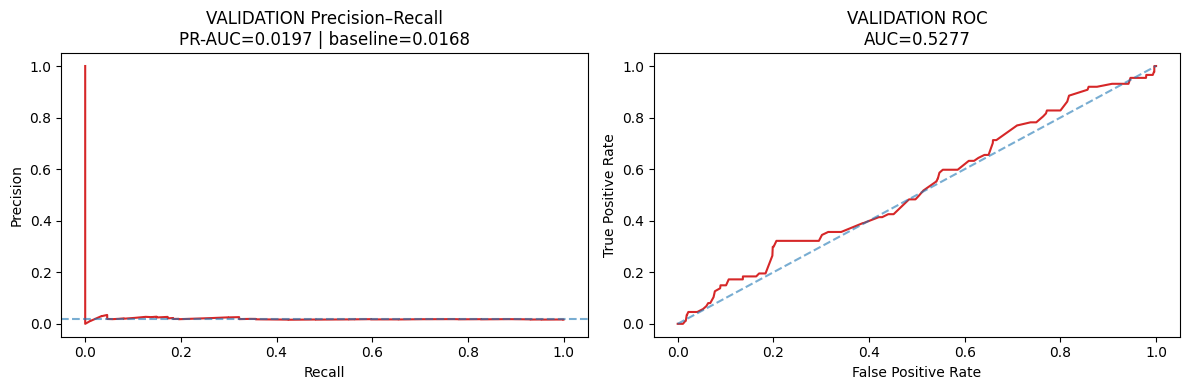


VALIDATION ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.0000 |    0.0000 |   0.00
    5% |  0.0575 |    0.0194 |   1.15
   10% |  0.1494 |    0.0251 |   1.49


In [50]:
val_metrics = plot_model_val_auc(y_val, p_val_lr_base, name="VALIDATION", color="tab:red")

val_topK = rank_metrics_at_k(y_val, p_val_lr_base, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK, title="VALIDATION")


#plot_cumulative_gain(y_val, p_val, name="VALIDATION", color="tab:green")



###LogisticRegression with Cross Validation and GridSearch

Class-weighted Logistic Regression (which up-weights the rare positive class to counter the 1–2% prevalence) is fitted and tuned with **5-fold GroupKFold** by patient_id to avoid same-patient leakage across folds. Then **GridSearch** explores **L1 vs L2 regularization** (sparsity/selective feature use vs smooth shrinkage) and **different regularization strengths** (C) to select the best setting by **cross-validated** PR-AUC.

In [51]:
target_col = "target"
categorical_cols = ["sex", "age_bin", "site_grp", "sex_x_site", "agebin_x_site"]
numeric_cols = [
    "age", "patient_img_count", "patient_any_pos", "patient_pos_rate",
    "age_missing", "sex_missing", "site_missing",
]
feature_cols = categorical_cols + numeric_cols

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].astype(int).copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].astype(int).copy()

logger.info(
    "LogisticRegression metadata (GridSearch): %s",
    info_dict({"train_rows": len(train_df), "val_rows": len(val_df)}),
)
logger.info("Number of features: %s", info_dict({"n_features": len(feature_cols)}))
logger.info(
    "image-level positive rates: %s",
    info_dict(
        {
            "train_pos_pct": round(100 * float(y_train.mean()), 2),
            "val_pos_pct": round(100 * float(y_val.mean()), 2),
        }
    ),
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        (
            "num",
            Pipeline(
                steps=[
                    ("imp", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_cols,
        ),
    ],
    remainder="drop",
)

# Cross-validation and GridSearch on Train
from sklearn.model_selection import GroupKFold, GridSearchCV

require_columns(train_df, ["patient_id"])
# prevents same-patient leakage across folds
groups = train_df["patient_id"].values

base_pipe = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=4000, class_weight="balanced")),
    ]
)

param_grid = {
    "model__solver": ["liblinear"],
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

cv = GroupKFold(n_splits=5)

gs = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

gs.fit(X_train, y_train, groups=groups)

logger.info(
    "GridSearchCV best: %s",
    info_dict(
        {
            "best_cv_pr_auc": round(float(gs.best_score_), 5),
            "best_params": gs.best_params_,
        }
    ),
)

lr_model = gs.best_estimator_

# Evaluate on VAL (model selection metric)
p_val_lr_tuned = lr_model.predict_proba(X_val)[:, 1]
val_pr_auc = float(average_precision_score(y_val, p_val_lr_tuned))

logger.info(
    "LogisticRegression metadata PR-AUC (tuned): %s",
    info_dict({"val_pr_auc": round(val_pr_auc, 5)}),
)


INFO: LogisticRegression metadata (GridSearch): train_rows=21585 | val_rows=5170
INFO: Number of features: n_features=12
INFO: image-level positive rates: train_pos_pct=1.8 | val_pos_pct=1.68
INFO: GridSearchCV best: best_cv_pr_auc=0.31942 | best_params={'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
INFO: LogisticRegression metadata PR-AUC (tuned): val_pr_auc=0.02533


[VALIDATION] PR-AUC=0.02533 | ROC-AUC=0.58207 | prevalence=0.01683


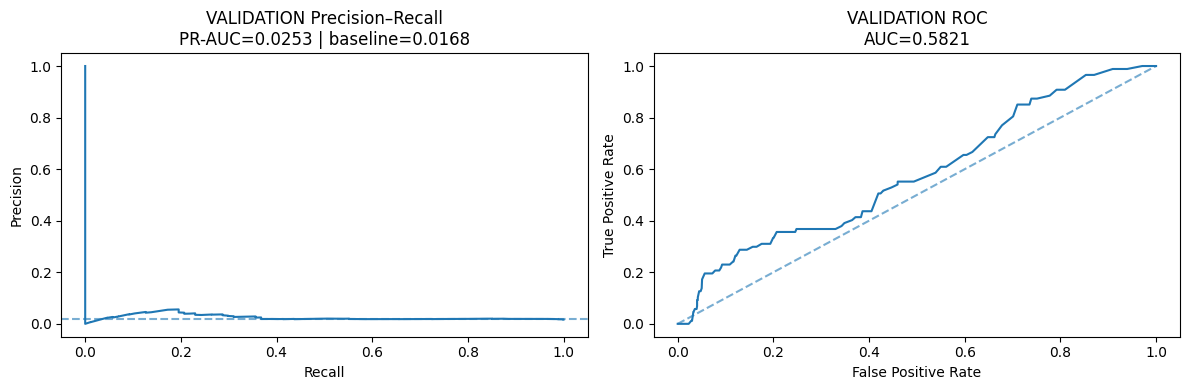


VALIDATION ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.0000 |    0.0000 |   0.00
    5% |  0.1264 |    0.0426 |   2.53
   10% |  0.2299 |    0.0387 |   2.30


In [52]:
val_metrics = plot_model_val_auc(y_val, p_val_lr_tuned, name="VALIDATION", color="tab:blue")
val_topK = rank_metrics_at_k(y_val, p_val_lr_tuned, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK, title="VALIDATION")
#plot_cumulative_gain(y_val, p_val, name="VALIDATION", color="tab:green")

##Gradient Boosted Decision Trees (GBDT) - HistGradientBoostingClassifier

Trained a metadata-only **HistGradientBoostingClassifier** with one-hot encoded categorical features and median-imputed numeric features. I used HistGradientBoostingClassifier because **Gradient Boosted Decision Trees** can capture non linear relationships and feature interactions that logistic regression often misses.

In [53]:
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].astype(int).copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].astype(int).copy()

logger.info(
    "HistGradientBoosting metadata baseline: %s",
    info_dict({"train_rows": len(train_df), "val_rows": len(val_df)}),
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", SimpleImputer(strategy="median"), numeric_cols),
    ],
    remainder="drop",
)

tree_model = Pipeline(
    steps=[
        ("prep", preprocess_tree),
        ("model", HistGradientBoostingClassifier(random_state=SEED)),
    ]
)

tree_model.fit(X_train, y_train)

# Evaluate on VAL (model selection metric)
p_val_tree = tree_model.predict_proba(X_val)[:, 1]
val_pr_auc_tree = float(average_precision_score(y_val, p_val_tree))

logger.info(
    "HistGradientBoosting metadata PR-AUC: %s",
    info_dict({"val_pr_auc": round(val_pr_auc_tree, 5)}),
)


INFO: HistGradientBoosting metadata baseline: train_rows=21585 | val_rows=5170
INFO: HistGradientBoosting metadata PR-AUC: val_pr_auc=0.01839


[VALIDATION] PR-AUC=0.01839 | ROC-AUC=0.53924 | prevalence=0.01683


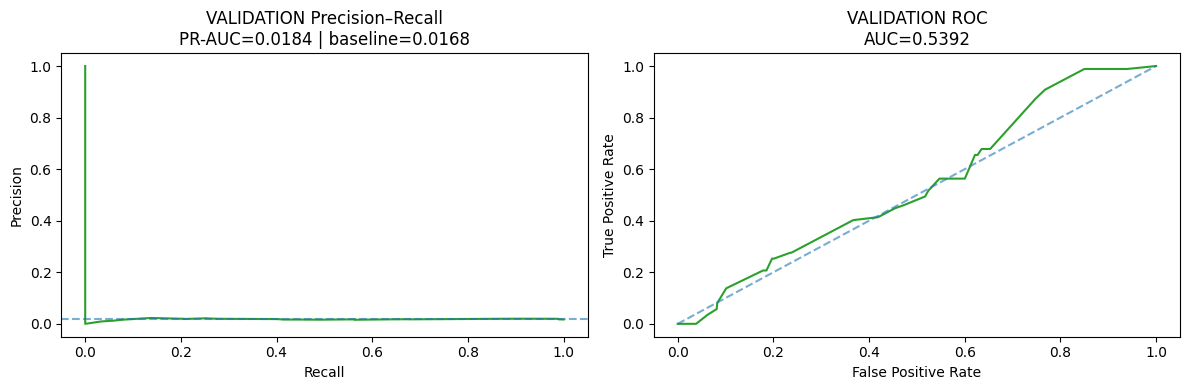


VALIDATION ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.0000 |    0.0000 |   0.00
    5% |  0.0000 |    0.0000 |   0.00
   10% |  0.1379 |    0.0232 |   1.38


In [54]:
val_metrics = plot_model_val_auc(y_val, p_val_tree, name="VALIDATION", color="tab:green")
val_topK = rank_metrics_at_k(y_val, p_val_tree, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK, title="VALIDATION")


##Convolutional Neural Network (CNN) Model - EfficientNet-B0
I chose it because it is widely used for image classification, often outperforming much larger models like ResNet with significantly fewer parameters. Pretrained on ImageNet dataset images features that transfer well, so head-only training is a reliable.

Training strategy: Freeze backbone and train only classifier head.

Used (torchvision) for light augmentation (flip and small rotation).

Imbalance handling: Used pos_weight = neg/pos inside **BCEWithLogitsLoss** to upweight positives (malignant).

Used **AdamW** optimizer during training to update the model’s trainable weights and to reduce the **loss**.


In [55]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info("device=%s", device)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 2

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))

# Transforms
train_tfms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

eval_tfms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Dataset
class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        with Image.open(img_path) as im:
            img = im.convert("RGB")
        x = self.tfms(img)
        y = torch.tensor(float(row["target"]), dtype=torch.float32)
        return x, y

# Loaders (TRAIN/VAL only)
train_loader = DataLoader(
    ISICDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)
val_loader = DataLoader(
    ISICDataset(val_df, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# Model
def build_effnet_b0(pretrained: bool = True) -> nn.Module:
    try:
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        model = models.efficientnet_b0(weights=weights)
    except Exception:
        model = models.efficientnet_b0(pretrained=pretrained)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)  # binary logits
    return model.to(device)

model_cnn_efficientnet_b0 = build_effnet_b0(pretrained=True)

# Freeze backbone; train head only (baseline)
for p in model_cnn_efficientnet_b0.features.parameters():
    p.requires_grad = False
for p in model_cnn_efficientnet_b0.classifier.parameters():
    p.requires_grad = True

# Class imbalance handling
y_train_np = train_df["target"].values.astype(np.float32)
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - pos)
pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)

logger.info(
    "Head-only training: %s",
    info_dict(
        {
            "epochs": EPOCHS,
            "patience": PATIENCE,
            "batch_size": BATCH_SIZE,
            "pos_weight": None if pos_weight is None else round(float(pos_weight.item()), 2),
        }
    ),
)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model_cnn_efficientnet_b0.classifier.parameters(), lr=1e-3, weight_decay=1e-4)

@torch.no_grad()
def eval_pr_roc(model: nn.Module, loader: DataLoader):
    model_cnn_efficientnet_b0.eval()
    y_list, p_list = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        probs = torch.sigmoid(model_cnn_efficientnet_b0(x).squeeze(1)).detach().cpu().numpy()
        p_list.append(probs)
        y_list.append(y.numpy())
    y_true = np.concatenate(y_list).astype(int)
    y_prob = np.concatenate(p_list)
    return (
        float(average_precision_score(y_true, y_prob)),
        float(roc_auc_score(y_true, y_prob)),
    )

# Train loop with early stopping on VAL PR-AUC
best_val_pr = -1.0
bad_epochs = 0
ckpt_path = artifact_output_directory / "model_cnn_efficientnet_b0_headonly_best.pt"

for epoch in range(1, EPOCHS + 1):
    model_cnn_efficientnet_b0.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model_cnn_efficientnet_b0(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model_cnn_efficientnet_b0, val_loader)

    logger.info(
        "epoch=%d | train_loss=%.4f | val_pr=%.4f | val_roc=%.4f",
        epoch,
        train_loss,
        val_pr,
        val_roc,
    )

    if val_pr > best_val_pr:
        best_val_pr = val_pr
        bad_epochs = 0
        torch.save({"model_state": model_cnn_efficientnet_b0.state_dict(), "img_size": IMG_SIZE}, str(ckpt_path))
        logger.info("Saved new best checkpoint: %s", ckpt_path.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("Early stopping (patience=%d).", PATIENCE)
            break

# Load best checkpoint and report VAL only
ckpt = torch.load(str(ckpt_path), map_location=device)
model_cnn_efficientnet_b0.load_state_dict(ckpt["model_state"])

val_pr, val_roc = eval_pr_roc(model_cnn_efficientnet_b0, val_loader)
logger.info(
    "EffNetB0 head-only (best ckpt): %s",
    info_dict({"best_val_pr": round(best_val_pr, 5), "val_pr": round(val_pr, 5), "val_roc": round(val_roc, 5)}),
)

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


INFO: device=cuda
INFO: Train prevalence (%): 1.80
INFO: Head-only training: epochs=10 | patience=2 | batch_size=32 | pos_weight=54.63
INFO: epoch=1 | train_loss=1.1410 | val_pr=0.0749 | val_roc=0.8179
INFO: Saved new best checkpoint: model_cnn_efficientnet_b0_headonly_best.pt
INFO: epoch=2 | train_loss=0.9988 | val_pr=0.0858 | val_roc=0.8123
INFO: Saved new best checkpoint: model_cnn_efficientnet_b0_headonly_best.pt
INFO: epoch=3 | train_loss=0.9807 | val_pr=0.0855 | val_roc=0.7979
INFO: epoch=4 | train_loss=0.9553 | val_pr=0.0929 | val_roc=0.8142
INFO: Saved new best checkpoint: model_cnn_efficientnet_b0_headonly_best.pt
INFO: epoch=5 | train_loss=0.9176 | val_pr=0.0851 | val_roc=0.8240
INFO: epoch=6 | train_loss=0.9641 | val_pr=0.0870 | val_roc=0.8286
INFO: Early stopping (patience=2).
INFO: EffNetB0 head-only (best ckpt): best_val_pr=0.09295 | val_pr=0.09295 | val_roc=0.81424


[VALIDATION | CNN_EFFB0] PR-AUC=0.09295 | ROC-AUC=0.81424 | prevalence=0.01683


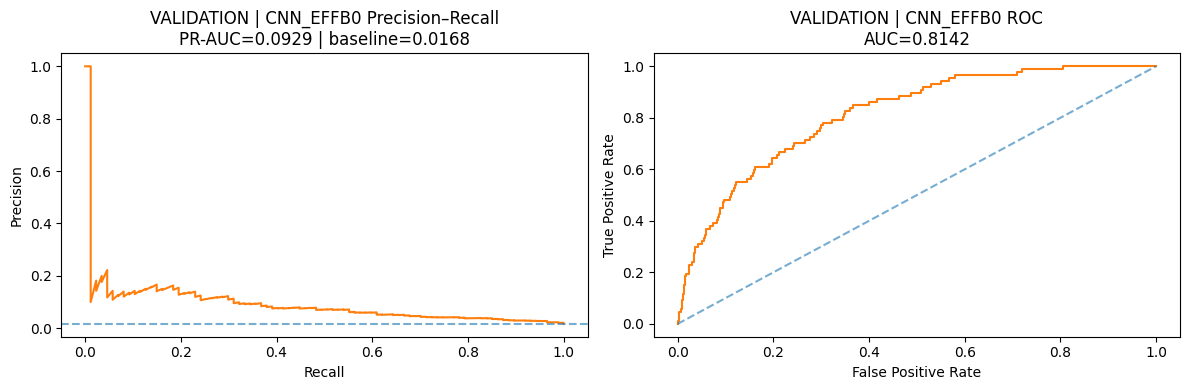


VALIDATION | CNN_EFFB0 ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.0805 |    0.1346 |   8.00
    5% |  0.3103 |    0.1047 |   6.22
   10% |  0.4483 |    0.0754 |   4.48


In [56]:
y_val, p_val = collect_probs_from_loader(model_cnn_efficientnet_b0, val_loader, device=device)

val_metrics = plot_model_val_auc(y_val, p_val, name="VALIDATION | CNN_EFFB0", color="tab:orange")
val_topK = rank_metrics_at_k(y_val, p_val, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK, title="VALIDATION | CNN_EFFB0")


##Convolutional Neural Network (CNN) Model - EfficientNet-B0 with image augmentaion using **Albumentations**
The training pipeline uses **Albumentations** to apply a richer and more diverse set of image augmentations.
Each training image is first resized to a fixed input size. It is then randomly flipped horizontally and vertically to improve invariance to orientation. Next, an affine transformation is applied, which includes small random translations, scaling, and rotations of up to ±20 degrees to increase geometric robustness.

After the geometric transformations, color and illumination variations are introduced through random brightness and contrast adjustments, hue and saturation shifts, and gamma corrections. To further improve robustness to image quality variations common in real-world data, the pipeline occasionally applies mild blurring or Gaussian noise. Finally, the image is normalized using ImageNet mean and standard deviation and converted into a PyTorch tensor using ToTensorV2

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 2

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),

        # geometry
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.90, 1.10),
            rotate=(-20, 20),
            p=0.9,
        ),

        # color / lighting
        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(p=0.4),
        A.RandomGamma(p=0.3),

        # mild robustness (low-res dataset)
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
                A.GaussNoise(std_range=(0.02, 0.08), p=1.0),
            ],
            p=0.3,
        ),

        # model expects normalized tensors
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

eval_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]

        with Image.open(img_path) as im:
            img = np.array(im.convert("RGB"))

        x = self.tfms(image=img)["image"]  # torch.Tensor CxHxW
        y = torch.tensor(row["target"], dtype=torch.float32)
        return x, y

train_loader = DataLoader(
    ISICDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    ISICDataset(val_df, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# Model
def build_effnet_b0(pretrained=True):
    try:
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        model = models.efficientnet_b0(weights=weights)
    except AttributeError:
        model = models.efficientnet_b0(pretrained=pretrained)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)
    return model.to(device)

model_cnn_eff_b0_albumentation = build_effnet_b0(pretrained=True)

# Freeze backbone, train head
for p in model_cnn_eff_b0_albumentation.features.parameters():
    p.requires_grad = False
for p in model_cnn_eff_b0_albumentation.classifier.parameters():
    p.requires_grad = True

# Imbalance handling (pos_weight)
y_train_np = train_df["target"].values.astype(np.float32)
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - pos)
pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)

logger.info(
    "Head-only training setup: %s",
    info_dict(
        {
            "epochs": EPOCHS,
            "patience": PATIENCE,
            "batch_size": BATCH_SIZE,
            "pos_weight": None if pos_weight is None else round(float(pos_weight.item()), 2),
        }
    ),
)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model_cnn_eff_b0_albumentation.classifier.parameters(), lr=1e-3, weight_decay=1e-4)

def eval_model(model, loader):
    model.eval()
    y_list, p_list = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())

    y_true = np.concatenate(y_list)
    y_prob = np.concatenate(p_list)
    return float(average_precision_score(y_true, y_prob)), float(roc_auc_score(y_true, y_prob))

# Train loop with early stopping (VAL only)
best_val_pr = -1.0
bad_epochs = 0
ckpt_path = artifact_output_directory / "model_cnn_efficientnet_b0_headonly_albumentation_best.pt"

for epoch in range(1, EPOCHS + 1):
    model_cnn_eff_b0_albumentation.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        logits = model_cnn_eff_b0_albumentation(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_model(model_cnn_eff_b0_albumentation, val_loader)

    logger.info("epoch=%d | train_loss=%.4f | val_pr=%.4f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr:
        best_val_pr = val_pr
        bad_epochs = 0
        torch.save({"model_state": model_cnn_eff_b0_albumentation.state_dict(), "img_size": IMG_SIZE}, str(ckpt_path))
        logger.info("Saved new best checkpoint: %s", ckpt_path.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("Early stopping (patience=%d).", PATIENCE)
            break

# Load best model (so later cells use best weights)
ckpt = torch.load(str(ckpt_path), map_location=device)
model_cnn_eff_b0_albumentation.load_state_dict(ckpt["model_state"])

logger.info(
    "Head-only best checkpoint (VAL only): %s",
    info_dict({"best_val_pr": round(best_val_pr, 5)}),
)

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


INFO: Train prevalence (%): 1.80
INFO: Head-only training setup: epochs=10 | patience=2 | batch_size=32 | pos_weight=54.63


device: cuda


INFO: epoch=1 | train_loss=1.1877 | val_pr=0.0831 | val_roc=0.8360
INFO: Saved new best checkpoint: model_cnn_efficientnet_b0_headonly_albumentation_best.pt
INFO: epoch=2 | train_loss=1.0813 | val_pr=0.0752 | val_roc=0.8218
INFO: epoch=3 | train_loss=1.0696 | val_pr=0.0843 | val_roc=0.8371
INFO: Saved new best checkpoint: model_cnn_efficientnet_b0_headonly_albumentation_best.pt
INFO: epoch=4 | train_loss=1.0431 | val_pr=0.0808 | val_roc=0.8347
INFO: epoch=5 | train_loss=1.0488 | val_pr=0.0811 | val_roc=0.8456
INFO: Early stopping (patience=2).
INFO: Head-only best checkpoint (VAL only): best_val_pr=0.08431


[VALIDATION | CNN_EffB0_Albu] PR-AUC=0.08431 | ROC-AUC=0.83707 | prevalence=0.01683


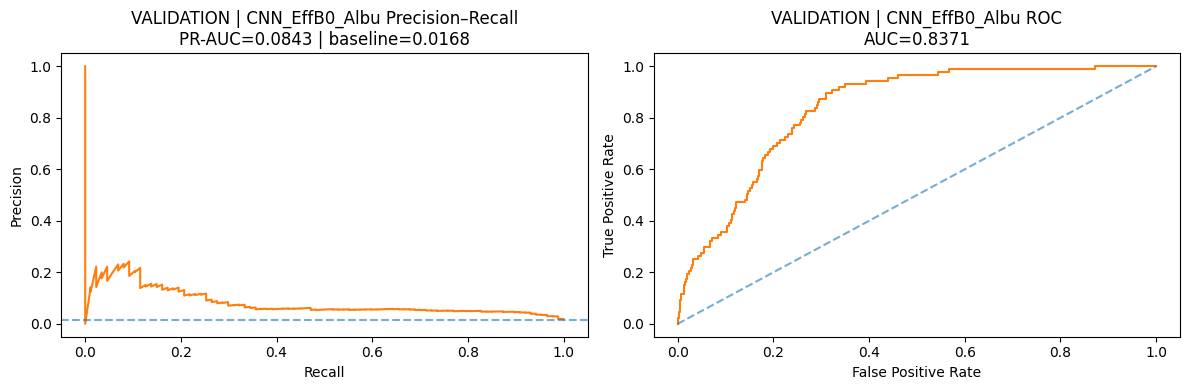


VALIDATION | CNN_EffB0_Albu ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.1149 |    0.1923 |  11.43
    5% |  0.2644 |    0.0891 |   5.30
   10% |  0.3563 |    0.0600 |   3.56


In [58]:
y_val, p_val = collect_probs_from_loader(model_cnn_eff_b0_albumentation, val_loader, device=device)

val_metrics = plot_model_val_auc(y_val, p_val, name="VALIDATION | CNN_EffB0_Albu", color="tab:orange")

val_topK = rank_metrics_at_k(y_val, p_val, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK, title="VALIDATION | CNN_EffB0_Albu")


##Convolutional Neural Network (CNN) Model EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation

Images are resized, augmented, normalized with ImageNet statistics, and converted to tensors, while class imbalance is handled using a weighted binary cross-entropy loss.
In Stage 1, the pretrained backbone is frozen and only the classifier head is trained, with validation PR-AUC used for early stopping and checkpoint selection.
In Stage 2, the best Stage 1 model is reloaded and only the final EfficientNet block plus the classifier head are fine-tuned using a lower learning rate for the backbone.
The final model is evaluated on the test set using PR-AUC and ROC-AUC.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

IMG_SIZE = 224
BATCH_SIZE = 32
PATIENCE = 2

EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 5

LR_HEAD_STAGE1 = 1e-3
LR_HEAD_STAGE2 = 1e-3
LR_LASTBLOCK_STAGE2 = 1e-4

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))

train_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.90, 1.10),
            rotate=(-20, 20),
            p=0.9,
        ),
        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(p=0.4),
        A.RandomGamma(p=0.3),
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
                A.GaussNoise(std_range=(0.02, 0.08), p=1.0),
            ],
            p=0.3,
        ),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

eval_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        with Image.open(row["filepath"]) as im:
            img = np.array(im.convert("RGB"))
        x = self.tfms(image=img)["image"]
        y = torch.tensor(float(row["target"]), dtype=torch.float32)
        return x, y

train_loader = DataLoader(
    ISICDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    ISICDataset(val_df, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# Model
try:
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model_cnn_eff_b0_2stage_album = models.efficientnet_b0(weights=weights)
except AttributeError:
    model_cnn_eff_b0_2stage_album = models.efficientnet_b0(pretrained=True)

in_features = model_cnn_eff_b0_2stage_album.classifier[1].in_features
model_cnn_eff_b0_2stage_album.classifier[1] = nn.Linear(in_features, 1)
model_cnn_eff_b0_2stage_album = model_cnn_eff_b0_2stage_album.to(device)

# Imbalance handling (pos_weight)
y_train_np = train_df["target"].values.astype(np.float32)
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - pos)
pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
logger.info("pos_weight: %s", None if pos_weight is None else round(float(pos_weight.item()), 2))

def eval_pr_roc(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())
    y_true = np.concatenate(y_list)
    y_prob = np.concatenate(p_list)
    return float(average_precision_score(y_true, y_prob)), float(roc_auc_score(y_true, y_prob))


# Stage 1: Train head-only
for p in model_cnn_eff_b0_2stage_album.features.parameters():
    p.requires_grad = False
for p in model_cnn_eff_b0_2stage_album.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    model_cnn_eff_b0_2stage_album.classifier.parameters(),
    lr=LR_HEAD_STAGE1,
    weight_decay=1e-4
)

best_val_pr = -1.0
bad_epochs = 0
ckpt_stage1 = artifact_output_directory / "model_cnn_eff_b0_2stage_album_stage1_headonly_best.pt"

for epoch in range(1, EPOCHS_STAGE1 + 1):
    model_cnn_eff_b0_2stage_album.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model_cnn_eff_b0_2stage_album(x).squeeze(1), y)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model_cnn_eff_b0_2stage_album, val_loader)

    logger.info("S1 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr:
        best_val_pr = val_pr
        bad_epochs = 0
        torch.save({"model_state": model_cnn_eff_b0_2stage_album.state_dict(), "img_size": IMG_SIZE}, str(ckpt_stage1))
        logger.info("S1 saved best: %s", ckpt_stage1.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S1 early stopping (patience=%d)", PATIENCE)
            break

logger.info("Stage 1 best_val_pr=%.5f | ckpt=%s", best_val_pr, ckpt_stage1.name)

# Load best Stage 1 before Stage 2
ckpt = torch.load(str(ckpt_stage1), map_location=device)
model_cnn_eff_b0_2stage_album.load_state_dict(ckpt["model_state"])

# Stage 2: Fine-tune last block + head
for p in model_cnn_eff_b0_2stage_album.features.parameters():
    p.requires_grad = False
for p in model_cnn_eff_b0_2stage_album.features[-1].parameters():
    p.requires_grad = True
for p in model_cnn_eff_b0_2stage_album.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    [
        {"params": model_cnn_eff_b0_2stage_album.classifier.parameters(), "lr": LR_HEAD_STAGE2},
        {"params": model_cnn_eff_b0_2stage_album.features[-1].parameters(), "lr": LR_LASTBLOCK_STAGE2},
    ],
    weight_decay=1e-4,
)

ckpt_stage2 = artifact_output_directory / "model_cnn_eff_b0_2stage_album_stage2_lastblock_best.pt"
best_val_pr2 = -1.0
bad_epochs = 0

for epoch in range(1, EPOCHS_STAGE2 + 1):
    model_cnn_eff_b0_2stage_album.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model_cnn_eff_b0_2stage_album(x).squeeze(1), y)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model_cnn_eff_b0_2stage_album, val_loader)

    logger.info("S2 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr2:
        best_val_pr2 = val_pr
        bad_epochs = 0
        torch.save({"model_state": model_cnn_eff_b0_2stage_album.state_dict(), "img_size": IMG_SIZE}, str(ckpt_stage2))
        logger.info("S2 saved best: %s", ckpt_stage2.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S2 early stopping (patience=%d)", PATIENCE)
            break

logger.info("Stage 2 best_val_pr=%.5f | ckpt=%s", best_val_pr2, ckpt_stage2.name)

# Load best Stage 2 (VAL-selected)
if not ckpt_stage2.exists():
    raise FileNotFoundError(f"Stage 2 checkpoint not saved: {ckpt_stage2}")

ckpt = torch.load(str(ckpt_stage2), map_location=device)
model_cnn_eff_b0_2stage_album.load_state_dict(ckpt["model_state"])

logger.info(
    "Final (Stage2 best, VAL-selected): %s",
    info_dict({"best_val_pr_stage2": round(best_val_pr2, 5), "ckpt": ckpt_stage2.name}),
)

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


INFO: Train prevalence (%): 1.80


device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s]
INFO: pos_weight: 54.63
INFO: S1 epoch=1 | loss=1.2192 | val_pr=0.11044 | val_roc=0.8423
INFO: S1 saved best: model_cnn_eff_b0_2stage_album_stage1_headonly_best.pt
INFO: S1 epoch=2 | loss=1.0964 | val_pr=0.08349 | val_roc=0.8449
INFO: S1 epoch=3 | loss=1.0644 | val_pr=0.08760 | val_roc=0.8435
INFO: S1 early stopping (patience=2)
INFO: Stage 1 best_val_pr=0.11044 | ckpt=model_cnn_eff_b0_2stage_album_stage1_headonly_best.pt
INFO: S2 epoch=1 | loss=1.1070 | val_pr=0.09632 | val_roc=0.8307
INFO: S2 saved best: model_cnn_eff_b0_2stage_album_stage2_lastblock_best.pt
INFO: S2 epoch=2 | loss=1.0640 | val_pr=0.10753 | val_roc=0.8502
INFO: S2 saved best: model_cnn_eff_b0_2stage_album_stage2_lastblock_best.pt
INFO: S2 epoch=3 | loss=1.0652 | val_pr=0.10211 | val_roc=0.8461
INFO: S2 epoch=4 | loss=1.0085 | val_pr=0.10728 | val_roc=0.8556
INFO: S2 early stopping (patience=2)
INFO: Stage 2 best_val_pr=0.10753 | ckpt=model_cnn_eff_b0_2stage_album_st

[VALIDATION | CNN_EffB0_2stage_Albu] PR-AUC=0.10753 | ROC-AUC=0.85020 | prevalence=0.01683


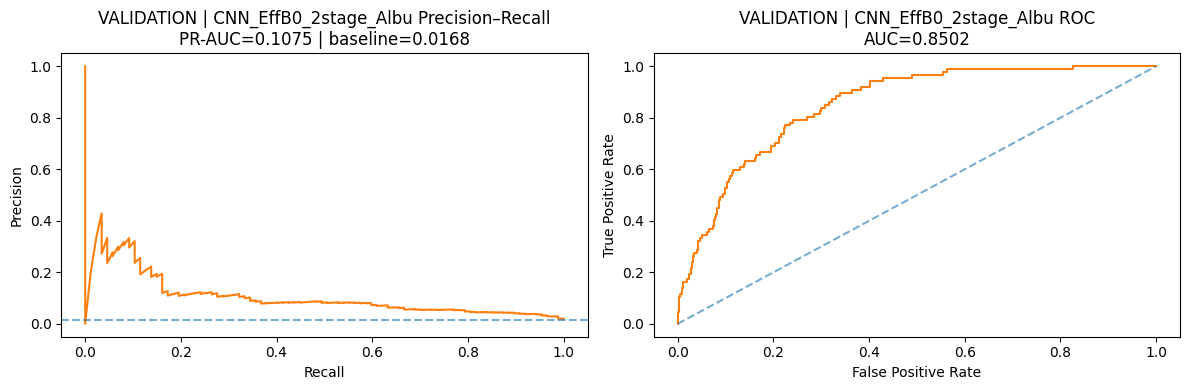


VALIDATION | CNN_EffB0_2stage_Albu ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.1149 |    0.1923 |  11.43
    5% |  0.3218 |    0.1085 |   6.45
   10% |  0.4943 |    0.0832 |   4.94


In [16]:
# validation only
y_val, p_val = collect_probs_from_loader(model_cnn_eff_b0_2stage_album, val_loader, device=device)

val_metrics = plot_model_val_auc(y_val, p_val, name="VALIDATION | CNN_EffB0_2stage_Albu", color="tab:orange")

val_topK = rank_metrics_at_k(y_val, p_val, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK, title="VALIDATION | CNN_EffB0_2stage_Albu")

# plot_cumulative_gain(y_val, p_val, name="VALIDATION | CNN_EffB0_2stage_Albu", color="tab:red")


# plot_cumulative_gain(y_val, p_val, name="VALIDATION", color="tab:red")

## Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation and imbalance handling with **WeightedRandomSampler**

 1) Two-stage fine-tune: (S1) head-only, (S2) last block + head (lower LR)
 2) Imbalance handling : WeightedRandomSampler
 3) Loss : BCEWithLogitsLoss
 4) Stronger Albumentations aug: Affine and color and blur/noise and coarse dropout


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

IMG_SIZE = 224
BATCH_SIZE = 32
PATIENCE = 2

EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 5

LR_HEAD_STAGE1 = 1e-3
LR_HEAD_STAGE2 = 5e-4
LR_LASTBLOCK_STAGE2 = 1e-4

USE_SAMPLER = True
USE_POS_WEIGHT = False
assert not (USE_SAMPLER and USE_POS_WEIGHT)

USE_FOCAL = False
FOCAL_GAMMA = 2.0

run_tag = "effb0_albu_s2_wrs"  # keep unique per experiment

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

logger.info("Train prevalence (%%): %.2f", 100 * float(train_df["target"].mean()))
logger.info("Imbalance mode: %s", "sampler" if USE_SAMPLER else ("pos_weight" if USE_POS_WEIGHT else "none"))
logger.info("Loss: %s", "focal" if USE_FOCAL else "bce")

train_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.90, 1.10),
            rotate=(-20, 20),
            shear=(-8, 8),
            p=0.9,
        ),

        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(p=0.4),
        A.RandomGamma(p=0.3),

        A.OneOf(
            [
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
                A.GaussNoise(std_range=(0.02, 0.08), p=1.0),
            ],
            p=0.3,
        ),

        A.CoarseDropout(
            num_holes_range=(1, 4),
            hole_height_range=(0.05, 0.15),
            hole_width_range=(0.05, 0.15),
            p=0.2,
        ),

        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

eval_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        with Image.open(row["filepath"]) as im:
            img = np.array(im.convert("RGB"))
        x = self.tfms(image=img)["image"]
        y = torch.tensor(float(row["target"]), dtype=torch.float32)
        return x, y


train_dataset = ISICDataset(train_df, train_tfms)
val_dataset   = ISICDataset(val_df, eval_tfms)
test_dataset  = ISICDataset(test_df, eval_tfms)

train_sampler = None
if USE_SAMPLER:
    y_train = train_df["target"].values.astype(int)
    class_counts = np.bincount(y_train, minlength=2).astype(float)
    class_weights = 1.0 / np.maximum(class_counts, 1.0)
    sample_weights = class_weights[y_train]
    train_sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),
        replacement=True,
    )

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=(train_sampler is None),
    sampler=train_sampler,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)
# Model
try:
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model_cnn_eff_b0_2stage_strong_album_wrs = models.efficientnet_b0(weights=weights)
except AttributeError:
    model_cnn_eff_b0_2stage_strong_album_wrs = models.efficientnet_b0(pretrained=True)

in_features = model_cnn_eff_b0_2stage_strong_album_wrs.classifier[1].in_features
model_cnn_eff_b0_2stage_strong_album_wrs.classifier[1] = nn.Linear(in_features, 1)
model_cnn_eff_b0_2stage_strong_album_wrs = model_cnn_eff_b0_2stage_strong_album_wrs.to(device)

pos_weight = None
if USE_POS_WEIGHT:
    y_train_np = train_df["target"].values.astype(np.float32)
    pos = float(y_train_np.sum())
    neg = float(len(y_train_np) - pos)
    pos_weight = None if pos == 0 else torch.tensor([neg / pos], dtype=torch.float32, device=device)
    logger.info("pos_weight: %s", None if pos_weight is None else round(float(pos_weight.item()), 2))

bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

def focal_loss(logits, targets, gamma=2.0):
    bce_per = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    p = torch.sigmoid(logits)
    pt = p * targets + (1 - p) * (1 - targets)
    loss = bce_per * ((1 - pt) ** gamma)
    return loss.mean()

def eval_pr_roc(model, loader):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            probs = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            p_list.append(probs)
            y_list.append(y.numpy())
    y_true = np.concatenate(y_list)
    y_prob = np.concatenate(p_list)
    return float(average_precision_score(y_true, y_prob)), float(roc_auc_score(y_true, y_prob))

# Stage 1: head-only
for p in model_cnn_eff_b0_2stage_strong_album_wrs.features.parameters():
    p.requires_grad = False
for p in model_cnn_eff_b0_2stage_strong_album_wrs.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    model_cnn_eff_b0_2stage_strong_album_wrs.classifier.parameters(),
    lr=LR_HEAD_STAGE1,
    weight_decay=1e-4,
)

best_val_pr_s1 = -1.0
bad_epochs = 0
ckpt_s1 = artifact_output_directory / f"{run_tag}_stage1_head_best.pt"

for epoch in range(1, EPOCHS_STAGE1 + 1):
    model_cnn_eff_b0_2stage_strong_album_wrs.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model_cnn_eff_b0_2stage_strong_album_wrs(x).squeeze(1)

        loss = focal_loss(logits, y, gamma=FOCAL_GAMMA) if USE_FOCAL else bce(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model_cnn_eff_b0_2stage_strong_album_wrs, val_loader)

    logger.info("S1 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr_s1:
        best_val_pr_s1 = val_pr
        bad_epochs = 0
        torch.save({"model_state": model_cnn_eff_b0_2stage_strong_album_wrs.state_dict(), "img_size": IMG_SIZE}, str(ckpt_s1))
        logger.info("S1 saved best: %s", ckpt_s1.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S1 early stopping (patience=%d)", PATIENCE)
            break

# Load best S1
ckpt = torch.load(str(ckpt_s1), map_location=device)
model_cnn_eff_b0_2stage_strong_album_wrs.load_state_dict(ckpt["model_state"])
logger.info("Stage 1 best_val_pr=%.5f | ckpt=%s", best_val_pr_s1, ckpt_s1.name)


# Stage 2: last block + head
for p in model_cnn_eff_b0_2stage_strong_album_wrs.features.parameters():
    p.requires_grad = False
for p in model_cnn_eff_b0_2stage_strong_album_wrs.features[-1].parameters():
    p.requires_grad = True
for p in model_cnn_eff_b0_2stage_strong_album_wrs.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    [
        {"params": model_cnn_eff_b0_2stage_strong_album_wrs.classifier.parameters(), "lr": LR_HEAD_STAGE2},
        {"params": model_cnn_eff_b0_2stage_strong_album_wrs.features[-1].parameters(), "lr": LR_LASTBLOCK_STAGE2},
    ],
    weight_decay=1e-4,
)

best_val_pr_s2 = best_val_pr_s1
bad_epochs = 0
ckpt_s2 = artifact_output_directory / "model_cnn_eff_b0_2stage_strong_album_wrs_lastblock_best.pt"

for epoch in range(1, EPOCHS_STAGE2 + 1):
    model_cnn_eff_b0_2stage_strong_album_wrs.train()
    losses = []

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model_cnn_eff_b0_2stage_strong_album_wrs(x).squeeze(1)

        loss = focal_loss(logits, y, gamma=FOCAL_GAMMA) if USE_FOCAL else bce(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    train_loss = float(np.mean(losses)) if losses else float("nan")
    val_pr, val_roc = eval_pr_roc(model_cnn_eff_b0_2stage_strong_album_wrs, val_loader)

    logger.info("S2 epoch=%d | loss=%.4f | val_pr=%.5f | val_roc=%.4f", epoch, train_loss, val_pr, val_roc)

    if val_pr > best_val_pr_s2:
        best_val_pr_s2 = val_pr
        bad_epochs = 0
        torch.save({"model_state": model_cnn_eff_b0_2stage_strong_album_wrs.state_dict(), "img_size": IMG_SIZE}, str(ckpt_s2))
        logger.info("S2 saved best: %s", ckpt_s2.name)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            logger.info("S2 early stopping (patience=%d)", PATIENCE)
            break

logger.info("Stage 2 best_val_pr=%.5f | ckpt=%s", best_val_pr_s2, ckpt_s2.name)

# Load best Stage 2 so later plotting cells use best weights
if not ckpt_s2.exists():
    raise FileNotFoundError(f"Stage 2 checkpoint not saved: {ckpt_s2}")

ckpt = torch.load(str(ckpt_s2), map_location=device)
model_cnn_eff_b0_2stage_strong_album_wrs.load_state_dict(ckpt["model_state"])

y_test, p_test = collect_probs_from_loader(
    model_cnn_eff_b0_2stage_strong_album_wrs, test_loader, device=device
)

logger.info(
    "Final (Stage2 best, VAL-selected): %s",
    info_dict({"best_val_pr_stage2": round(best_val_pr_s2, 5), "ckpt": ckpt_s2.name}),
)

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


INFO: Train prevalence (%): 1.80
INFO: Imbalance mode: sampler
INFO: Loss: bce


device: cuda


INFO: S1 epoch=1 | loss=0.5514 | val_pr=0.09729 | val_roc=0.8456
INFO: S1 saved best: effb0_albu_s2_wrs_stage1_head_best.pt
INFO: S1 epoch=2 | loss=0.5189 | val_pr=0.08304 | val_roc=0.8393
INFO: S1 epoch=3 | loss=0.5082 | val_pr=0.07997 | val_roc=0.8370
INFO: S1 early stopping (patience=2)
INFO: Stage 1 best_val_pr=0.09729 | ckpt=effb0_albu_s2_wrs_stage1_head_best.pt
INFO: S2 epoch=1 | loss=0.5008 | val_pr=0.09460 | val_roc=0.8562
INFO: S2 epoch=2 | loss=0.4674 | val_pr=0.09527 | val_roc=0.8531
INFO: S2 early stopping (patience=2)
INFO: Stage 2 best_val_pr=0.09729 | ckpt=model_cnn_eff_b0_2stage_strong_album_wrs_lastblock_best.pt
INFO: Final (Stage2 best, VAL-selected): best_val_pr_stage2=0.09729 | ckpt=model_cnn_eff_b0_2stage_strong_album_wrs_lastblock_best.pt


[VALIDATION | CNN_EffB0_2stage_strong_Albu_WRS] PR-AUC=0.10868 | ROC-AUC=0.85861 | prevalence=0.01683


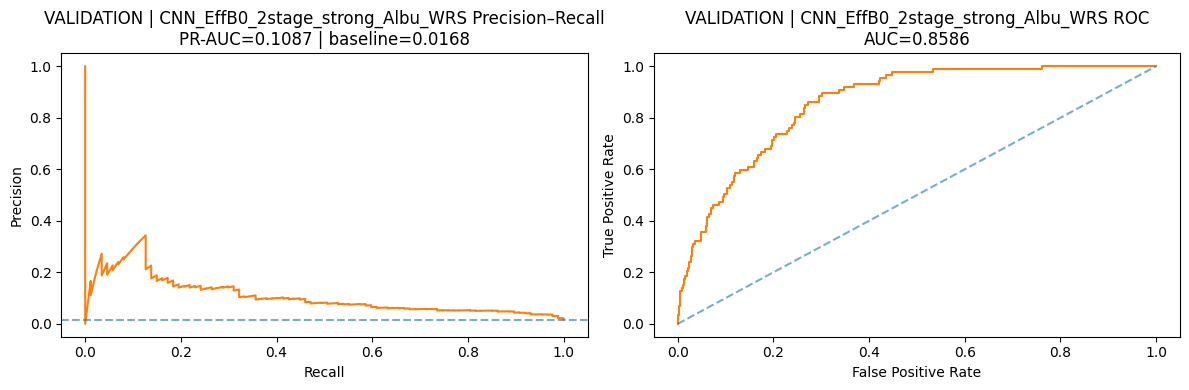


VALIDATION | CNN_EffB0_2stage_strong_Albu_WRS ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.1264 |    0.2115 |  12.57
    5% |  0.3218 |    0.1085 |   6.45
   10% |  0.4713 |    0.0793 |   4.71


In [17]:
y_val, p_val = collect_probs_from_loader(model_cnn_eff_b0_2stage_strong_album_wrs, val_loader, device=device)

plot_model_val_auc(y_val, p_val, name="VALIDATION | CNN_EffB0_2stage_strong_Albu_WRS", color="tab:orange")

val_topK = rank_metrics_at_k(y_val, p_val, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK, title="VALIDATION | CNN_EffB0_2stage_strong_Albu_WRS")


##STACKING - IMAGE MODEL: Convolutional Neural Network (CNN) Model - EfficientNet-B0 using two stage fine tuning and strong albumentation and weightedRandomSampler with METADATA MODEL: LogisticRegression with Cross Validation and GridSearch

This code builds a stacked ensemble that combines the EfficientNet-B0 CNN trained with strong Albumentations augmentation and WeightedRandomSampler with the tuned metadata LogisticRegression (GroupKFold/GridSearch). It generates out-of-fold (OOF) probability predictions for both base models on the TRAIN set (K=3), fits a LogisticRegression stacker on those OOF features, and then evaluates the stacker on VAL using model probabilities.

In [63]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

K_FOLDS = 3

IMG_SIZE = 224
BATCH_SIZE = 32
PATIENCE = 1
EPOCHS_STAGE1 = 4
EPOCHS_STAGE2 = 2
LR_HEAD_STAGE1 = 1e-3
LR_HEAD_STAGE2 = 5e-4
LR_LASTBLOCK_STAGE2 = 1e-4

USE_SAMPLER = True
USE_POS_WEIGHT = False
assert not (USE_SAMPLER and USE_POS_WEIGHT)

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Affine(
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.90, 1.10),
            rotate=(-20, 20),
            shear=(-8, 8),
            p=0.9,
        ),
        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(p=0.4),
        A.RandomGamma(p=0.3),
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
                A.GaussNoise(std_range=(0.02, 0.08), p=1.0),
            ],
            p=0.3,
        ),
        A.CoarseDropout(
            num_holes_range=(1, 4),
            hole_height_range=(0.05, 0.15),
            hole_width_range=(0.05, 0.15),
            p=0.2,
        ),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

eval_tfms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ]
)

class ISICDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        with Image.open(row["filepath"]) as im:
            img = np.array(im.convert("RGB"))
        x = self.tfms(image=img)["image"]
        y = torch.tensor(float(row["target"]), dtype=torch.float32)
        return x, y


def make_loader(df, tfms, *, shuffle, sampler=None, batch_size=BATCH_SIZE):
    ds = ISICDataset(df, tfms)
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle if sampler is None else False,
        sampler=sampler,
        num_workers=0,
        pin_memory=(device.type == "cuda"),
    )


def make_weighted_sampler(df):
    y = df["target"].values.astype(int)
    class_counts = np.bincount(y, minlength=2).astype(float)
    class_weights = 1.0 / np.maximum(class_counts, 1.0)
    sample_weights = class_weights[y]
    return WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),
        replacement=True,
    )


def build_effnet_b0_binary():
    try:
        weights = models.EfficientNet_B0_Weights.DEFAULT
        m = models.efficientnet_b0(weights=weights)
    except AttributeError:
        m = models.efficientnet_b0(pretrained=True)

    in_features = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_features, 1)
    return m.to(device)


@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    y_list, p_list = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
        y_list.append(y.detach().cpu().numpy())
        p_list.append(p)
    y_true = np.concatenate(y_list).astype(int)
    p_prob = np.concatenate(p_list).astype(float)
    return y_true, p_prob


def train_two_stage_fast(model, train_loader, val_loader):
    # Stage 1: head-only
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = True

    criterion = nn.BCEWithLogitsLoss()
    opt = torch.optim.AdamW(model.classifier.parameters(), lr=LR_HEAD_STAGE1, weight_decay=1e-4)

    best_pr = -1.0
    bad = 0
    best_state = None

    for epoch in range(EPOCHS_STAGE1):
        model.train()
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            loss = criterion(model(x).squeeze(1), y)
            loss.backward()
            opt.step()

        y_val, p_val = predict_probs(model, val_loader)
        pr = float(average_precision_score(y_val, p_val))

        if pr > best_pr:
            best_pr = pr
            bad = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad += 1
            if bad >= PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state, strict=True)

    # Stage 2: last block + head
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.features[-1].parameters():
        p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True

    opt = torch.optim.AdamW(
        [
            {"params": model.classifier.parameters(), "lr": LR_HEAD_STAGE2},
            {"params": model.features[-1].parameters(), "lr": LR_LASTBLOCK_STAGE2},
        ],
        weight_decay=1e-4,
    )

    best_pr2 = best_pr
    bad = 0
    best_state2 = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    for epoch in range(EPOCHS_STAGE2):
        model.train()
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            loss = criterion(model(x).squeeze(1), y)
            loss.backward()
            opt.step()

        y_val, p_val = predict_probs(model, val_loader)
        pr = float(average_precision_score(y_val, p_val))

        if pr > best_pr2:
            best_pr2 = pr
            bad = 0
            best_state2 = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad += 1
            if bad >= PATIENCE:
                break

    model.load_state_dict(best_state2, strict=True)
    return model

target_col = "target"
categorical_cols = ["sex", "age_bin", "site_grp", "sex_x_site", "agebin_x_site"]
numeric_cols = [
    "age",
    "patient_img_count",
    "patient_any_pos",
    "patient_pos_rate",
    "age_missing",
    "sex_missing",
    "site_missing",
]
feature_cols = categorical_cols + numeric_cols

def build_lr_tuned_pipeline(C=0.1, penalty="l1"):
    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
        ],
        remainder="drop",
    )
    return Pipeline(
        steps=[
            ("prep", preprocess),
            ("model", LogisticRegression(max_iter=4000, class_weight="balanced", solver="liblinear", C=C, penalty=penalty)),
        ]
    )

# Best params from GridSearch
LRMETA_C = 0.1
LRMETA_PENALTY = "l1"

_t0 = time.time()
logger.info(
    "[SETUP] device=%s | K=%d | IMG_SIZE=%d | BS=%d | PATIENCE=%d | S1=%d S2=%d | sampler=%s | seed=%d",
    device, K_FOLDS, IMG_SIZE, BATCH_SIZE, PATIENCE, EPOCHS_STAGE1, EPOCHS_STAGE2, USE_SAMPLER, SEED
)
logger.info(
    "[DATA] train_rows=%d | val_rows=%d | train_prev=%.5f | val_prev=%.5f",
    len(train_df), len(val_df),
    float(train_df[target_col].mean()), float(val_df[target_col].mean())
)

# GroupKFold split (patient leakage-safe)
groups = train_df["patient_id"].values
y_train_true = train_df[target_col].astype(int).values
gkf = GroupKFold(n_splits=K_FOLDS)

# Metadata OOF on TRAIN
logger.info("[META OOF] start | train_rows=%d | K=%d | params: C=%s penalty=%s",
            len(train_df), K_FOLDS, LRMETA_C, LRMETA_PENALTY)

oof_meta = np.zeros(len(train_df), dtype=float)

for fold, (tr_idx, te_idx) in enumerate(gkf.split(train_df, y_train_true, groups=groups), start=1):
    logger.info("[META OOF][fold %d/%d] fit=%d | oof=%d", fold, K_FOLDS, len(tr_idx), len(te_idx))

    df_tr = train_df.iloc[tr_idx]
    df_te = train_df.iloc[te_idx]

    lr_meta_fold = build_lr_tuned_pipeline(C=LRMETA_C, penalty=LRMETA_PENALTY)
    lr_meta_fold.fit(df_tr[feature_cols].copy(), df_tr[target_col].astype(int).values)

    oof_meta[te_idx] = lr_meta_fold.predict_proba(df_te[feature_cols].copy())[:, 1].astype(float)

    fold_pr = float(average_precision_score(y_train_true[te_idx], oof_meta[te_idx]))
    logger.info("[META OOF][fold %d] oof_fold_pr=%.5f | elapsed=%.1fs", fold, fold_pr, time.time() - _t0)

meta_oof_pr = float(average_precision_score(y_train_true, oof_meta))
logger.info("[META OOF] done | oof_pr=%.5f | elapsed=%.1fs", meta_oof_pr, time.time() - _t0)

# Final metadata model on full TRAIN for VAL inference
lr_model_final = build_lr_tuned_pipeline(C=LRMETA_C, penalty=LRMETA_PENALTY)
lr_model_final.fit(train_df[feature_cols].copy(), y_train_true)

y_val_true = val_df[target_col].astype(int).values
p_val_meta = lr_model_final.predict_proba(val_df[feature_cols].copy())[:, 1].astype(float)

logger.info("[META FINAL] val_pr=%.5f | val_roc=%.5f",
            float(average_precision_score(y_val_true, p_val_meta)),
            float(roc_auc_score(y_val_true, p_val_meta)))

# CNN OOF on TRAIN
logger.info("[CNN OOF] start | train_rows=%d | K=%d", len(train_df), K_FOLDS)

oof_cnn = np.zeros(len(train_df), dtype=float)

for fold, (tr_idx, te_idx) in enumerate(gkf.split(train_df, y_train_true, groups=groups), start=1):
    logger.info("[CNN OOF][fold %d/%d] train=%d | holdout=%d", fold, K_FOLDS, len(tr_idx), len(te_idx))

    df_tr = train_df.iloc[tr_idx].reset_index(drop=True)
    df_te = train_df.iloc[te_idx].reset_index(drop=True)

    sampler = make_weighted_sampler(df_tr) if USE_SAMPLER else None
    tr_loader = make_loader(df_tr, train_tfms, shuffle=(sampler is None), sampler=sampler)
    te_loader = make_loader(df_te, eval_tfms, shuffle=False)

    model_fold = build_effnet_b0_binary()
    model_fold = train_two_stage_fast(model_fold, tr_loader, te_loader)

    y_te, p_te = predict_probs(model_fold, te_loader)
    oof_cnn[te_idx] = p_te

    fold_pr = float(average_precision_score(y_train_true[te_idx], oof_cnn[te_idx]))
    logger.info("[CNN OOF][fold %d] oof_fold_pr=%.5f | elapsed=%.1fs", fold, fold_pr, time.time() - _t0)

    del model_fold
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()

cnn_oof_pr = float(average_precision_score(y_train_true, oof_cnn))
logger.info("[CNN OOF] done | oof_pr=%.5f | elapsed=%.1fs", cnn_oof_pr, time.time() - _t0)

# Final CNN on full TRAIN for VAL inference
sampler_full = make_weighted_sampler(train_df) if USE_SAMPLER else None
train_loader_full = make_loader(train_df, train_tfms, shuffle=(sampler_full is None), sampler=sampler_full)
val_loader_full = make_loader(val_df, eval_tfms, shuffle=False)

model_cnn_final_for_stack = build_effnet_b0_binary()
model_cnn_final_for_stack = train_two_stage_fast(model_cnn_final_for_stack, train_loader_full, val_loader_full)

y_val_cnn, p_val_cnn = predict_probs(model_cnn_final_for_stack, val_loader_full)

logger.info("[CNN FINAL] val_pr=%.5f | val_roc=%.5f",
            float(average_precision_score(y_val_cnn, p_val_cnn)),
            float(roc_auc_score(y_val_cnn, p_val_cnn)))

# Stacker (train on OOF TRAIN features, eval on VAL features)
X_oof = np.column_stack([oof_cnn, oof_meta])
X_val_stack = np.column_stack([p_val_cnn, p_val_meta])

logger.info("[STACK] fit on OOF features: X_oof=%s | y_train=%s", str(X_oof.shape), str(y_train_true.shape))

stacker_oof_cnn_lrmeta_k3 = LogisticRegression(max_iter=4000, class_weight="balanced")
stacker_oof_cnn_lrmeta_k3.fit(X_oof, y_train_true)

p_val_stack = stacker_oof_cnn_lrmeta_k3.predict_proba(X_val_stack)[:, 1].astype(float)

# Save for plotting cell
y_val_stack = y_val_true
p_val_stack_oof = p_val_stack

stack_pr = float(average_precision_score(y_val_stack, p_val_stack_oof))
stack_roc = float(roc_auc_score(y_val_stack, p_val_stack_oof))
logger.info("[STACK] VAL PR-AUC=%.5f | VAL ROC-AUC=%.5f | elapsed=%.1fs", stack_pr, stack_roc, time.time() - _t0)


INFO: [SETUP] device=cuda | K=3 | IMG_SIZE=224 | BS=32 | PATIENCE=1 | S1=4 S2=2 | sampler=True | seed=42
INFO: [DATA] train_rows=21585 | val_rows=5170 | train_prev=0.01798 | val_prev=0.01683
INFO: [META OOF] start | train_rows=21585 | K=3 | params: C=0.1 penalty=l1
INFO: [META OOF][fold 1/3] fit=14390 | oof=7195


device: cuda


INFO: [META OOF][fold 1] oof_fold_pr=0.30095 | elapsed=0.4s
INFO: [META OOF][fold 2/3] fit=14389 | oof=7196
INFO: [META OOF][fold 2] oof_fold_pr=0.32587 | elapsed=0.7s
INFO: [META OOF][fold 3/3] fit=14391 | oof=7194
INFO: [META OOF][fold 3] oof_fold_pr=0.33690 | elapsed=1.1s
INFO: [META OOF] done | oof_pr=0.32019 | elapsed=1.1s
INFO: [META FINAL] val_pr=0.02159 | val_roc=0.56489
INFO: [CNN OOF] start | train_rows=21585 | K=3
INFO: [CNN OOF][fold 1/3] train=14390 | holdout=7195
INFO: [CNN OOF][fold 1] oof_fold_pr=0.11835 | elapsed=423.3s
INFO: [CNN OOF][fold 2/3] train=14389 | holdout=7196
INFO: [CNN OOF][fold 2] oof_fold_pr=0.09982 | elapsed=706.9s
INFO: [CNN OOF][fold 3/3] train=14391 | holdout=7194
INFO: [CNN OOF][fold 3] oof_fold_pr=0.08059 | elapsed=991.3s
INFO: [CNN OOF] done | oof_pr=0.08849 | elapsed=991.5s
INFO: [CNN FINAL] val_pr=0.09558 | val_roc=0.84888
INFO: [STACK] fit on OOF features: X_oof=(21585, 2) | y_train=(21585,)
INFO: [STACK] VAL PR-AUC=0.09434 | VAL ROC-AUC=0.849

[VALIDATION | STACK OOF(K=3) (CNN & LRmeta_tuned)] PR-AUC=0.09434 | ROC-AUC=0.84907 | prevalence=0.01683


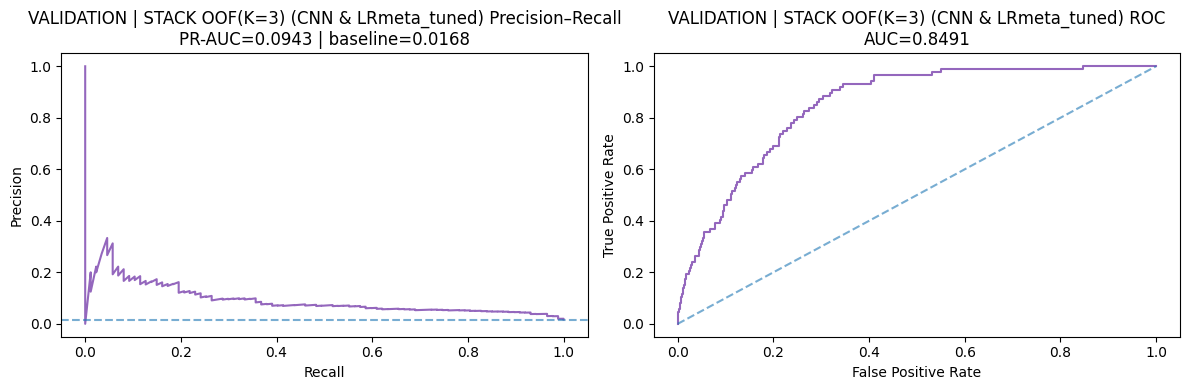


VALIDATION | STACK OOF(K=3) ranking metrics (prevalence=0.0168)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.1034 |    0.1731 |  10.29
    5% |  0.2874 |    0.0969 |   5.76
   10% |  0.4138 |    0.0696 |   4.14


In [67]:
#plot
plot_model_val_auc(y_val_stack,p_val_stack_oof,
    name="VALIDATION | STACK OOF(K=3) (CNN & LRmeta_tuned)",
    color="tab:purple",
)

val_topK_stack = rank_metrics_at_k(y_val_stack, p_val_stack_oof, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(val_topK_stack, title="VALIDATION | STACK OOF(K=3)")


##Evaluate best performing model on unseen TEST set
Convolutional Neural Network (CNN) Model - EfficientNet-B0 classifier using a two-stage fine-tuning approach with Albumentations-based image augmentation and imbalance handling with WeightedRandomSampler had the best rank using PR-AUC.

[TEST | CNN_EffB0_2stage_strong_Albu_WRS] PR-AUC=0.13381 | ROC-AUC=0.86871 | prevalence=0.01711


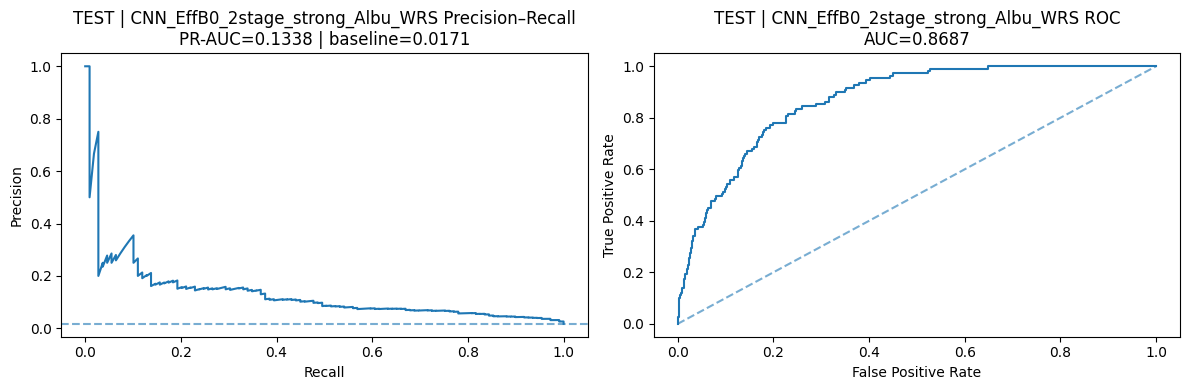


TEST | CNN_EffB0_2stage_strong_Albu_WRS ranking metrics (prevalence=0.0171)
 Top K |  Recall | Precision |   Lift
--------------------------------------
    1% |  0.1193 |    0.2031 |  11.87
    5% |  0.3761 |    0.1285 |   7.51
   10% |  0.5046 |    0.0863 |   5.05


In [73]:
def collect_probs_from_loader(model, loader, *, device):
    model.eval()
    y_list, p_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
            y_list.append(y.detach().cpu().numpy())
            p_list.append(p)
    y_true = np.concatenate(y_list).astype(int)
    p_prob = np.concatenate(p_list).astype(float)
    return y_true, p_prob

# TEST (probability-based evaluation)
y_test, p_test = collect_probs_from_loader(
    model_cnn_eff_b0_2stage_strong_album_wrs, test_loader, device=device
)

plot_model_val_auc(
    y_test,
    p_test,
    name="TEST | CNN_EffB0_2stage_strong_Albu_WRS",
    color="tab:blue",
)

test_topK = rank_metrics_at_k(y_test, p_test, ks=(0.01, 0.05, 0.10))
print_rank_metrics_at_k(test_topK, title="TEST | CNN_EffB0_2stage_strong_Albu_WRS")



##CONFUSION MATRIX
I chose an operating threshold with highest precision on the VAL set so that the model achieves recall ≥ 0.85

Then applied that fixed, VAL chosen threshold to the TEST set to produce 0/1 predictions, and confusion matrix

Chosen threshold on VAL (recall≥0.85): 0.339062

TEST confusion matrix @ VAL-chosen threshold
  TN=4317 | FP=1945 | FN=15 | TP=94
  Precision=0.0461 | Recall=0.8624 | FPR=0.3106

TEST classification report @ VAL-chosen threshold
              precision    recall  f1-score   support

           0     0.9965    0.6894    0.8150      6262
           1     0.0461    0.8624    0.0875       109

    accuracy                         0.6924      6371
   macro avg     0.5213    0.7759    0.4513      6371
weighted avg     0.9803    0.6924    0.8025      6371



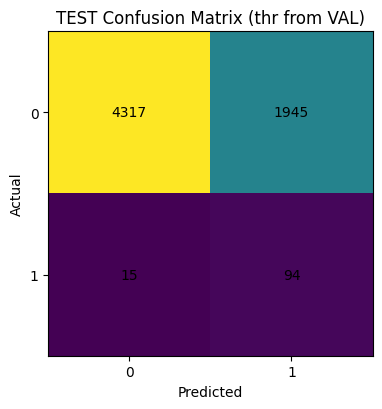

In [74]:
def plot_confusion_matrix(cm, *, title
    fig, ax = plt.subplots(figsize=(4.6, 4.2))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])

    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.show()

# Threshold on VAL to target recall >= 0.85
y_val, p_val = collect_probs_from_loader(
    model_cnn_eff_b0_2stage_strong_album_wrs, val_loader, device=device
)

target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, p_val)

precision_t = precision[1:]
recall_t = recall[1:]
valid = np.where(recall_t >= target_recall)[0]

if len(valid) == 0:
    chosen_thresh = 0.5
else:
    # among thresholds that hit recall target, pick the one with best precision
    i = valid[np.argmax(precision_t[valid])]
    chosen_thresh = float(thresholds[i])

print(f"Chosen threshold on VAL (recall≥{target_recall:.2f}): {chosen_thresh:.6f}")

# Apply the VAL threshold to TEST
y_pred_test = (p_test >= chosen_thresh).astype(int)

cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
tn, fp, fn, tp = (int(cm[0,0]), int(cm[0,1]), int(cm[1,0]), int(cm[1,1]))

test_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
test_precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
test_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

print("\nTEST confusion matrix @ VAL-chosen threshold")
print(f"  TN={tn} | FP={fp} | FN={fn} | TP={tp}")
print(f"  Precision={test_precision:.4f} | Recall={test_recall:.4f} | FPR={test_fpr:.4f}")
print("\nTEST classification report @ VAL-chosen threshold")
print(classification_report(y_test, y_pred_test, digits=4))

plot_confusion_matrix(cm, title="TEST Confusion Matrix (thr from VAL)")
